In [2]:
import numpy as np
import pandas as pd
from google.cloud import bigquery, storage
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, t
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML
import math
import statsmodels.api as sm
from typing import Union
import logging
import sys
from google.cloud.exceptions import NotFound
import time
import os
import json
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google.auth import default
from typing import Union
from datetime import date, timedelta, datetime
from tqdm.auto import tqdm
import fastparquet as fp
import io
from joblib import Parallel, delayed
import gc
import numpy as np


# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s:%(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)
    ],
    force=True
)


# ------------------------------------------------------------------------------
# Data Queries
# ------------------------------------------------------------------------------

def get_marketing_data(entities, week, vertical):
    
    mkt_data = f"""

    WITH holdout_entities AS (
    SELECT 
        entity_id,
        MIN(CASE WHEN is_customer_holdout THEN created_date END) AS release_date
    FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
    WHERE 
        is_customer_holdout = TRUE 
        AND created_date < '{week}'
        AND entity_id in {entities}
    GROUP BY entity_id
    HAVING COUNT(CASE WHEN is_customer_holdout THEN customer_id END) > 100
    ),
    orders as (
    SELECT
        dps.entity_id entity_id
        ,dps.dps_customer_id customer_id
        ,COUNT(case when mkt.order_date <= e.release_date then mkt.order_id end) AS orders_pre
        ,COUNT(case when mkt.order_date > e.release_date then mkt.order_id end) AS orders_post
        ,SUM(case when mkt.order_date <= e.release_date then mkt.analytical_profit end) AS analytical_profit_pre
        ,SUM(case when mkt.order_date > e.release_date then mkt.analytical_profit end) AS analytical_profit_post
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps
    JOIN holdout_entities AS e
        ON dps.entity_id = e.entity_id
    left join fulfillment-dwh-production.curated_data_shared_mkt.bima_order_profitability mkt
        ON mkt.global_entity_id = dps.entity_id
        AND mkt.order_id = dps.platform_order_code
        AND order_date >= DATE_SUB(release_date, INTERVAL 8 WEEK)
        AND order_date < '{week}'
        AND global_entity_id in {entities}
    WHERE dps.created_date >= DATE_SUB(e.release_date, INTERVAL 8 WEEK) 
        AND dps.created_date < '{week}'
        AND dps.platform_order_code IS NOT NULL
        AND dps.is_own_delivery
        AND dps.is_sent
        AND vendor_vertical_parent IN ('Restaurant','restaurant','restaurants')
        AND dps.entity_id in {entities}
    GROUP BY 1, 2
    ), 
    customer_information AS (
    SELECT
            e.entity_id,
            e.release_date,
            CASE WHEN d.created_date <= e.release_date THEN FALSE ELSE COALESCE(is_customer_holdout, FALSE) END AS is_customer_holdout,
            d.customer_id
    FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
    JOIN holdout_entities AS e
            ON d.entity_id = e.entity_id
    LEFT JOIN `fulfillment-dwh-production.cl._bad_dps_logs_ids` bad_ids
        ON d.customer_id = bad_ids.id
    WHERE d.created_date >= '2025-01-01' 
        AND d.created_date < '{week}'
        AND d.customer_id IS NOT NULL
        AND bad_ids.id IS NULL
        AND d.entity_id in {entities}
    GROUP BY 1, 2, 3, 4
    )
    SELECT  p.brand_name,
            e.entity_id,
            e.customer_id,
            e.is_customer_holdout,
            o.orders_pre,
            o.orders_post,
            o.analytical_profit_pre,
            o.analytical_profit_post
    FROM customer_information e
    LEFT JOIN orders o
        ON o.customer_id = e.customer_id
        AND o.entity_id = e.entity_id
    LEFT JOIN (
        SELECT DISTINCT
            p.entity_id,
            c.country_name,
            c.region,
            CASE 
                WHEN p.brand_name IN ("Foodora", "Foodpanda", "Yemeksepeti") THEN "Pandora"
                WHEN p.brand_name IN ("eFood", "Foody") THEN "GR/CY"
                WHEN p.brand_name = "PedidosYa" THEN "PEYA"
                WHEN p.brand_name = "Baemin" THEN "Woowa"
                WHEN p.brand_name = "FoodPanda" THEN "FP APAC"
                ELSE p.brand_name
            END AS brand_name
        FROM `fulfillment-dwh-production.cl.countries` c
        LEFT JOIN UNNEST(c.platforms) p
    ) p
    ON e.entity_id = p.entity_id

    """

    return mkt_data


def get_dps_data(entities, week):

    dps_data = f"""

    WITH holdout_entities AS (
    SELECT 
        entity_id,
        MIN(CASE WHEN is_customer_holdout THEN created_date END) AS release_date
    FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
    WHERE 
        is_customer_holdout = TRUE 
        AND created_date < '{week}'
        AND entity_id in {entities}
    GROUP BY entity_id
    HAVING COUNT(CASE WHEN is_customer_holdout THEN customer_id END) > 100
    ),
    orders as (
    SELECT
         dps.entity_id entity_id
        ,dps.dps_customer_id customer_id
        ,COUNT(case when dps.created_date <= e.release_date then dps.platform_order_code end) AS orders_pre
        ,COUNT(case when dps.created_date > e.release_date then dps.platform_order_code end) AS orders_post
        ,SUM(case when dps.created_date <= e.release_date then dps.fully_loaded_gross_profit_eur end) AS analytical_profit_pre
        ,SUM(case when dps.created_date > e.release_date then dps.fully_loaded_gross_profit_eur end) AS analytical_profit_post
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps
    JOIN holdout_entities AS e
        ON dps.entity_id = e.entity_id
    WHERE dps.created_date >= DATE_SUB(e.release_date, INTERVAL 8 WEEK) 
        AND dps.created_date < '{week}'
        AND dps.platform_order_code IS NOT NULL
        AND dps.is_own_delivery
        AND dps.is_sent
        AND vendor_vertical_parent IN ('Restaurant','restaurant','restaurants')
        AND dps.entity_id not in {entities}
    GROUP BY 1, 2
    ), 
    customer_information AS (
    SELECT
            e.entity_id,
            e.release_date,
            CASE WHEN d.created_date <= e.release_date THEN FALSE ELSE COALESCE(is_customer_holdout, FALSE) END AS is_customer_holdout,
            d.customer_id
    FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
    JOIN holdout_entities AS e
            ON d.entity_id = e.entity_id
    LEFT JOIN `fulfillment-dwh-production.cl._bad_dps_logs_ids` bad_ids
        ON d.customer_id = bad_ids.id
    WHERE d.created_date BETWEEN '2025-01-01' AND '{week}'
        AND d.customer_id IS NOT NULL
        AND bad_ids.id IS NULL
    GROUP BY 1, 2, 3, 4
    )
    SELECT 
        p.brand_name,
        e.entity_id,
        e.customer_id,
        e.is_customer_holdout,
        o.orders_pre,
        o.orders_post,
        o.analytical_profit_pre,
        o.analytical_profit_post
    FROM customer_information e
    LEFT JOIN orders o
        ON o.customer_id = e.customer_id
        AND o.entity_id = e.entity_id
    LEFT JOIN (
        SELECT DISTINCT
            p.entity_id,
            c.country_name,
            c.region,
            CASE 
                WHEN p.brand_name IN ("Foodora", "Foodpanda", "Yemeksepeti") THEN "Pandora"
                WHEN p.brand_name IN ("eFood", "Foody") THEN "GR/CY"
                WHEN p.brand_name = "PedidosYa" THEN "PEYA"
                WHEN p.brand_name = "Baemin" THEN "Woowa"
                WHEN p.brand_name = "FoodPanda" THEN "FP APAC"
                ELSE p.brand_name
            END AS brand_name
        FROM `fulfillment-dwh-production.cl.countries` c
        LEFT JOIN UNNEST(c.platforms) p
    ) p
    ON e.entity_id = p.entity_id

    """

    return dps_data


def get_brands():

    brand = """

    select DISTINCT
            p.entity_id,
            c.country_name,
            c.region,
            (CASE 
                WHEN p.brand_name = "Foodora" OR p.brand_name = "Foodpanda" OR p.brand_name = "Yemeksepeti" THEN "Pandora"
                WHEN p.brand_name = "eFood" OR p.brand_name = "Foody" THEN "GR/CY"
                WHEN p.brand_name = "PedidosYa" THEN "PEYA"
                WHEN p.brand_name = "Baemin" THEN "Woowa"
                WHEN p.brand_name = "FoodPanda" THEN "FP APAC"
                ELSE p.brand_name
                END) brand_name
    from `fulfillment-dwh-production.cl.countries` c
    left join unnest(c.platforms) p

    """

    return brand

# ------------------------------------------------------------------------------
# Data Extraction
# ------------------------------------------------------------------------------

def initialize_bigquery_client(project_id_pass):
   
    project_id = project_id_pass 

    logging.info(f"Initializing BigQuery client for project: {project_id}")

    if os.getenv("GITHUB_ACTIONS"):
        credentials_path = "/tmp/credentials.json" 
    else:
        credentials, project = default()  
        project_id = project if project else project_id 

    if os.getenv("GITHUB_ACTIONS") and not os.path.exists(credentials_path):
        raise FileNotFoundError(f"Credentials file not found at {credentials_path}. Make sure to set up authentication in GitHub Actions.")

    if os.getenv("GITHUB_ACTIONS"):
        with open(credentials_path, "r") as f:
            creds_data = json.load(f)

        credentials = Credentials.from_authorized_user_info(creds_data)

        if credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())

    try:
        client = bigquery.Client(credentials=credentials, project=project_id)
        logging.info(f"BigQuery client initialized successfully for project: {project_id}")
        return client 
    except Exception as e:
        logging.error(f"Failed to initialize BigQuery client: {e}")
        raise e


def get_iso_week_mondays(year, min_date=None, max_date=None):
    d = date(year, 1, 4)
    d -= timedelta(days=d.weekday())

    mondays = []
    while d.year <= year or (d.year == year + 1 and d.isocalendar()[1] == 1):
        if (
            d.isocalendar()[0] == year and
            (min_date is None or d > min_date) and
            (max_date is None or d <= max_date)
        ):
            mondays.append(d)
        d += timedelta(weeks=1)

    return mondays

def combined_data(client, mkt, dps):
    
    try:
        mkt_df = client.query(mkt).to_dataframe()
    except Exception as e:
        logging.error(f"Error executing marketing data query: {e}")
        mkt_df = pd.DataFrame() 

    try:
        dps_df = client.query(dps).to_dataframe()
    except Exception as e:
        logging.error(f"Error executing DPS data query: {e}")
        dps_df = pd.DataFrame()

    combined = pd.concat([mkt_df, dps_df], ignore_index=True)

    return combined


def extract_data(client, mkt_data, dps_data):
    
    start_time = time.time()
    logging.info(f"start_time: {start_time:.2f}")

    combined_df = combined_data(client,mkt_data, dps_data)
    elapsed_time = time.time() - start_time
    logging.info(f"Time to extract and combine data from DB: {elapsed_time:.2f} seconds")
    
    return combined_df 


def get_cumm_data(project,entities, week):

    client = initialize_bigquery_client(project)
    
    final_df = pd.DataFrame()

    for w_no in tqdm(week, desc=f'{week} - Week No', position=1):

    #for w_no in week:
        
        print(f"Querying for week starting {w_no}")
        
        tmp = extract_data(client ,get_marketing_data(entities, w_no), get_dps_data(entities,w_no))

        # Add the as_of_date column
        tmp["as_of_date"] = w_no

        # Append to the final dataframe
        final_df = pd.concat([final_df, tmp], ignore_index=True)

    return final_df


# ------------------------------------------------------------------------------
# Data Clean Up
# ------------------------------------------------------------------------------

def fill_nans(df):

    df = df.fillna({
        'orders_pre': 0,
        'orders_post': 0,
        'analytical_profit_pre': 0,
        'analytical_profit_post': 0,
    })

    return df

def drop_users_with_no_data(df):

    mask1 = (
        (df['orders_pre'] == 0) &
        (df['orders_post'] == 0) &
        (df['analytical_profit_pre'] == 0) &
        (df['analytical_profit_post'] == 0)
    )

    mask2 = (
        (df['orders_pre'].isna()) &
        (df['orders_post'].isna()) &
        (df['analytical_profit_pre'].isna()) &
        (df['analytical_profit_post'].isna())
    ) 

    df = df[~(mask1 |   mask2)]
    
    return df

def apply_cleanup(df):

    #NaN's are converted to 0's where applicable
    data_cleaned = fill_nans(df) 
    
    #remove customers with no data in the pre and the post period
    raw_data_final = drop_users_with_no_data(data_cleaned)

    return raw_data_final

# ------------------------------------------------------------------------------
# Performing Statistical Analysis
# ------------------------------------------------------------------------------


## Confidence Intervals for separate groups ##

def bootstrap_single_group(
    df: pd.DataFrame,
    adjusted_metric: str,
    n_resamples: int = 1000,
    alpha: float = 0.05,
    seed: int = 42
) -> dict:
    
    # Drop NaNs for safety
    group = df[adjusted_metric].dropna().values

    if len(group) == 0:
        raise ValueError(f"No valid data found for metric: {adjusted_metric}")

    # If all values are the same, skip bootstrap
    if np.all(group == group[0]):
        mean_val = group[0]
        return {
            "mean": round(mean_val, 4),
            "ci": (round(mean_val, 4), round(mean_val, 4))
        }

    # Use scipy's bootstrap with percentile CI
    res = stats.bootstrap(
        (group,),
        statistic=np.mean,
        n_resamples=n_resamples,
        method='percentile',
        confidence_level=1 - alpha,
        random_state=seed
    )

    bootstrap_means = res.bootstrap_distribution
    ci = res.confidence_interval
    mean_val = np.mean(group)
    bootstrap_mean = np.mean(bootstrap_means)

    return {
        "mean": round(mean_val, 4),
        "ci": (round(ci.low, 4), round(ci.high, 4)),
        "bootstrap_mean": round(bootstrap_mean, 4),
        "bootstrap_means" : bootstrap_means
    }

def plot_bootstrap_single_distribution(boot_result: dict, alpha: float = 0.05):
    
    boot_means = boot_result["bootstrap_means"]
    mean_val = boot_result["mean"]
    ci_low, ci_high = boot_result["ci"]

    plt.figure(figsize=(10, 6))
    plt.hist(boot_means, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val}')
    plt.axvline(ci_low, color='green', linestyle='--', linewidth=2, label=f'{100*(1-alpha):.0f}% CI Low: {ci_low}')
    plt.axvline(ci_high, color='green', linestyle='--', linewidth=2, label=f'{100*(1-alpha):.0f}% CI High: {ci_high}')
    
    plt.title("Bootstrap Distribution of the Mean")
    plt.xlabel("Mean Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_bootstrap_comparison_single_group(
    result1: dict, label1: str,
    result2: dict, label2: str,
    alpha: float = 0.05
):
    plt.figure(figsize=(12, 6))

    # Plot 1
    plt.hist(result1["boot_means"], bins=50, alpha=0.5, label=f'{label1} Dist', edgecolor='black')
    plt.axvline(result1["mean"], color='red', linestyle='--', label=f'{label1} Mean: {result1["mean"]}')
    plt.axvline(result1["ci"][0], color='green', linestyle='--', label=f'{label1} CI Low: {result1["ci"][0]}')
    plt.axvline(result1["ci"][1], color='green', linestyle='--', label=f'{label1} CI High: {result1["ci"][1]}')

    # Plot 2
    plt.hist(result2["boot_means"], bins=50, alpha=0.5, label=f'{label2} Dist', edgecolor='black')
    plt.axvline(result2["mean"], color='blue', linestyle='--', label=f'{label2} Mean: {result2["mean"]}')
    plt.axvline(result2["ci"][0], color='purple', linestyle='--', label=f'{label2} CI Low: {result2["ci"][0]}')
    plt.axvline(result2["ci"][1], color='purple', linestyle='--', label=f'{label2} CI High: {result2["ci"][1]}')

    plt.title("Bootstrap Distribution Comparison")
    plt.xlabel("Mean Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def t_confidence_interval(data, alpha=0.05):
    
    data = np.array(data)
    n = len(data)
    mean = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(n)
    t_crit = t.ppf(1 - alpha / 2, df=n - 1)

    ci_lower = mean - t_crit * sem
    ci_upper = mean + t_crit * sem

    return {
        "mean": round(mean,3),
        "ci": (round(ci_lower,3), round(ci_upper,3))
    }


## Confidence Intervals for the Difference in Means of Two Groups ##

# def bootstrap_diff_means(df: pd.DataFrame, adjusted_metric: str, n_resamples: int = 500, alpha: float = 0.05, seed: int = 42):
    
#     np.random.seed(seed)

#     # Split the data
#     group_a = df[df["is_customer_holdout"] == False][adjusted_metric].values
#     group_b = df[df["is_customer_holdout"] == True][adjusted_metric].values

#     total_non_holdout = df[df["is_customer_holdout"] == False][adjusted_metric].sum()
#     total_holdout = df[df["is_customer_holdout"] == True][adjusted_metric].sum()

#     # Unique user counts
#     n_users_non_holdout = df[df["is_customer_holdout"] == False]["customer_id"].nunique()
#     n_users_holdout = df[df["is_customer_holdout"] == True]["customer_id"].nunique()

#     mean_non_holdout = np.mean(group_a)
#     mean_holdout = np.mean(group_b)

#     logging.info("")
#     res = stats.bootstrap(
#         (group_a, group_b),
#         statistic=lambda a, b: np.mean(a) - np.mean(b),
#         n_resamples=n_resamples,
#         method='percentile',
#         random_state=seed
#     )

#     ci = res.confidence_interval
#     #boot_diffs = res.bootstrap_distribution

#     observed_diff = np.mean(group_a) - np.mean(group_b)

#     if mean_holdout != 0:
#         pct_diff = observed_diff / mean_holdout
#         pct_ci_low = ci.low / mean_holdout
#         pct_ci_high = ci.high / mean_holdout
#     else:
#         pct_diff, pct_ci_low, pct_ci_high = np.nan, np.nan, np.nan

#     # Compute two-tailed bootstrap p-value
#     #p_value = np.mean(np.abs(boot_diffs - np.mean(boot_diffs)) >= np.abs(observed_diff - np.mean(boot_diffs)))

#     bootstrap_ci_lb = round(ci.low, 4)
#     bootstrap_ci_ub = round(ci.high, 4)
#     #bootstrap_mean = round(np.mean(boot_diffs), 4)

#     print(f"Observed Mean Diff: {observed_diff:.4f}")
#     #print(f"Bootstrap Mean Diff: {bootstrap_mean}")
#     print(f"Bootstrap {100*(1-alpha):.0f}% CI: ({bootstrap_ci_lb}, {bootstrap_ci_ub})")
#     #print(f"Bootstrap P-value: {p_value:.4f}")
#     print(f"Users: Non-Holdout = {n_users_non_holdout}, Holdout = {n_users_holdout}")

#     return {
#         "observed_diff": observed_diff,
#         "mean_non_holdout": mean_non_holdout,
#         "mean_holdout": mean_holdout,
#         "ci": (bootstrap_ci_lb, bootstrap_ci_ub),
#         "pct_diff": pct_diff,
#         "pct_ci": (round(pct_ci_low, 4), round(pct_ci_high, 4)),
#         "total_non_holdout": total_non_holdout,
#         "total_holdout": total_holdout,
#         "n_users_non_holdout": n_users_non_holdout,
#         "n_users_holdout": n_users_holdout
#     }

def bootstrap_diff_means(
    df: pd.DataFrame,
    adjusted_metric: str,
    n_resamples: int = 1000,
    alpha: float = 0.05,
    seed: int = 42,
    store_boot_diffs: bool = False,
    verbose: bool = True
):
    rng = np.random.default_rng(seed)

    group_a = df[df["is_customer_holdout"] == False][adjusted_metric].values
    group_b = df[df["is_customer_holdout"] == True][adjusted_metric].values

    total_non_holdout = group_a.sum()
    total_holdout = group_b.sum()

    non_holdout = df[~df["is_customer_holdout"]]
    holdout = df[df["is_customer_holdout"]]
    n_users_non_holdout = non_holdout["customer_id"].nunique()
    n_users_holdout = holdout["customer_id"].nunique()

    mean_non_holdout = np.mean(group_a)
    mean_holdout = np.mean(group_b)

    res = stats.bootstrap(
        (group_a, group_b),
        statistic=lambda a, b: np.mean(a) - np.mean(b),
        n_resamples=n_resamples,
        method='percentile',
        random_state=rng
    )

    ci = res.confidence_interval
    observed_diff = mean_non_holdout - mean_holdout

    if np.isclose(mean_holdout, 0):
        pct_diff = observed_diff / abs(mean_holdout)
        pct_ci_low = ci.low / abs(mean_holdout)
        pct_ci_high = ci.high / abs(mean_holdout)
    else:
        pct_diff = pct_ci_low = pct_ci_high = np.nan

    bootstrap_ci_lb = round(ci.low, 4)
    bootstrap_ci_ub = round(ci.high, 4)
    bootstrap_mean = round(np.mean(res.bootstrap_distribution), 4)


    result = {
        "observed_diff": observed_diff,
        "bootstrap_mean": bootstrap_mean,
        "mean_non_holdout": mean_non_holdout,
        "mean_holdout": mean_holdout,
        "ci": (bootstrap_ci_lb, bootstrap_ci_ub),
        "pct_diff": pct_diff,
        "pct_ci": (round(pct_ci_low, 4), round(pct_ci_high, 4)),
        "total_non_holdout": total_non_holdout,
        "total_holdout": total_holdout,
        "n_users_non_holdout": n_users_non_holdout,
        "n_users_holdout": n_users_holdout
    }

    if store_boot_diffs:
        result["boot_diffs"] = res.bootstrap_distribution

    return result

def bootstrap_diff_means_parallel(
    df: pd.DataFrame,
    adjusted_metric: str,
    n_resamples: int = 1000,
    alpha: float = 0.05,
    seed: int = 42,
    store_boot_diffs: bool = False,
    n_jobs: int = -1,
):
    rng = np.random.default_rng(seed)

    group_a = df[~df["is_customer_holdout"]][adjusted_metric].values
    group_b = df[df["is_customer_holdout"]][adjusted_metric].values

    total_non_holdout = group_a.sum()
    total_holdout = group_b.sum()

    non_holdout = df[~df["is_customer_holdout"]]
    holdout = df[df["is_customer_holdout"]]
    n_users_non_holdout = non_holdout["customer_id"].nunique()
    n_users_holdout = holdout["customer_id"].nunique()

    mean_non_holdout = np.mean(group_a)
    mean_holdout = np.mean(group_b)
    observed_diff = mean_non_holdout - mean_holdout

    def single_resample(_):
        local_rng = np.random.default_rng(seed + _)

        resample_a = local_rng.choice(group_a, size=group_a.shape[0], replace=True)
        resample_b = local_rng.choice(group_b, size=group_b.shape[0], replace=True)

        return np.mean(resample_a) - np.mean(resample_b)

    diffs = Parallel(n_jobs=n_jobs)(
        delayed(single_resample)(i) for i in range(n_resamples)
    )

    diffs = np.array(diffs)
    ci_low = np.nanpercentile(diffs, 100 * (alpha / 2))
    ci_high = np.nanpercentile(diffs, 100 * (1 - alpha / 2))

    if not np.isclose(mean_holdout, 0):
        pct_diff = observed_diff / abs(mean_holdout)
        pct_ci_low = ci_low / abs(mean_holdout)
        pct_ci_high = ci_high / abs(mean_holdout)
    else:
        pct_diff = pct_ci_low = pct_ci_high = np.nan

    result = {
        "observed_diff": observed_diff,
        "bootstrap_mean": np.mean(diffs),
        "mean_non_holdout": mean_non_holdout,
        "mean_holdout": mean_holdout,
        "ci": (ci_low, ci_high),
        "pct_diff": pct_diff,
        "pct_ci": (pct_ci_low, pct_ci_high),
        "total_non_holdout": total_non_holdout,
        "total_holdout": total_holdout,
        "n_users_non_holdout": n_users_non_holdout,
        "n_users_holdout": n_users_holdout
    }

    if store_boot_diffs:
        result["boot_diffs"] = diffs

    return result


def bootstrap_profit_per_order_parallel(
    df: pd.DataFrame,
    profit_col: str,
    orders_col: str,
    n_resamples: int = 1000,
    alpha: float = 0.05,
    seed: int = 42,
    n_jobs: int = -1 
):
    rng = np.random.default_rng(seed)

    group_a = df[df["is_customer_holdout"] == False][[profit_col, orders_col]].values
    group_b = df[df["is_customer_holdout"] == True][[profit_col, orders_col]].values

    total_profit_non_holdout = group_a[:, 0].sum()
    total_orders_non_holdout = group_a[:, 1].sum()
    total_profit_holdout = group_b[:, 0].sum()
    total_orders_holdout = group_b[:, 1].sum()

    ratio_non_holdout = total_profit_non_holdout / total_orders_non_holdout if total_orders_non_holdout != 0 else np.nan
    ratio_holdout = total_profit_holdout / total_orders_holdout if total_orders_holdout != 0 else np.nan
    observed_diff = ratio_non_holdout - ratio_holdout

    def single_resample(_):
        
        local_rng = np.random.default_rng(seed + _)

        sample_a_idx = local_rng.integers(0, group_a.shape[0], group_a.shape[0])
        sample_b_idx = local_rng.integers(0, group_b.shape[0], group_b.shape[0])

        profit_a = group_a[sample_a_idx, 0].sum()
        orders_a = group_a[sample_a_idx, 1].sum()
        profit_b = group_b[sample_b_idx, 0].sum()
        orders_b = group_b[sample_b_idx, 1].sum()

        ratio_a = profit_a / orders_a if orders_a != 0 else np.nan
        ratio_b = profit_b / orders_b if orders_b != 0 else np.nan

        return ratio_a - ratio_b

    # ✅ PARALLEL BOOTSTRAPPING
    diffs = Parallel(n_jobs=n_jobs)(
        delayed(single_resample)(i) for i in range(n_resamples)
    )

    diffs = np.array(diffs)
    ci_low = np.nanpercentile(diffs, 100 * (alpha / 2))
    ci_high = np.nanpercentile(diffs, 100 * (1 - alpha / 2))

    return {
        "observed_diff": observed_diff,
        "ci": (ci_low, ci_high),
        "non_holdout_ratio": ratio_non_holdout,
        "holdout_ratio": ratio_holdout
    }


## applying confidence intervals ##

def apply_bootstrap_diff_means(
    df: pd.DataFrame,
    group_col: str,
    adjusted_metrics: list,
    n_resamples: int = 1000,
    alpha: float = 0.05,
    seed: int = 42
) -> pd.DataFrame:
    
    results = []

    all_groups = df[group_col].dropna().unique()
    all_weeks = sorted(df["as_of_date"].dropna().unique())

    for group_val in tqdm(all_groups, desc=f"{group_col} groups"):
        df_group = df[df[group_col] == group_val]

        for week in tqdm(all_weeks, desc="Weeks", leave=False):
            df_cumulative = df_group[df_group["as_of_date"] == week]

            if df_cumulative["is_customer_holdout"].nunique() < 2:
                continue

            row = {
                group_col: group_val,
                "as_of_date": week
            }

            for metric in adjusted_metrics:
                if metric not in df_cumulative.columns:
                    continue

                try:
                    result = bootstrap_diff_means_parallel(
                        df=df_cumulative,
                        adjusted_metric=metric,
                        n_resamples=n_resamples,
                        alpha=alpha,
                        seed=seed
                    )

                    # Add flattened metric results to row
                    row[f"{metric}_observed_diff"] = result["observed_diff"]
                    row[f"{metric}_ci_low"] = result["ci"][0]
                    row[f"{metric}_ci_high"] = result["ci"][1]
                    
                    # Absolute uplift = per-user diff × non-holdout user count
                    row[f"{metric}_abs_lift"] = result["observed_diff"] * result["n_users_non_holdout"]
                    row[f"{metric}_abs_ci_low"] = result["ci"][0] * result["n_users_non_holdout"]
                    row[f"{metric}_abs_ci_high"] = result["ci"][1] * result["n_users_non_holdout"]
                    
                    row[f"{metric}_pct_diff"] = result["pct_diff"]
                    row[f"{metric}_pct_ci_low"] = result["pct_ci"][0]
                    row[f"{metric}_pct_ci_high"] = result["pct_ci"][1]
                    
                    row[f"{metric}_total_non_holdout"] = result["total_non_holdout"]
                    row[f"{metric}_total_holdout"] = result["total_holdout"]
                                        
                    row[f"{metric}_mean_non_holdout"] = result["mean_non_holdout"]
                    row[f"{metric}_mean_holdout"] = result["mean_holdout"]
                    #row[f"{metric}_p_value"] = result["p_value"]
                    row[f"{metric}_n_users_non_holdout"] = result["n_users_non_holdout"]
                    row[f"{metric}_n_users_holdout"] = result["n_users_holdout"]
                    # Optionally: remove or comment out if too large
                    # row[f"{metric}_boot_diffs"] = result["boot_diffs"]

                except Exception as e:
                    print(f"Error with {group_col}={group_val}, week={week}, metric={metric}: {e}")
                    continue

            print(f"\nBrand/Entity: {group_val}")
            print(f"Week: {week.date()}")
            
            results.append(row)
            gc.collect()

    return pd.DataFrame(results)


# def apply_bootstrap_diff_means(
#     df: pd.DataFrame,
#     group_col: str,
#     adjusted_metrics: list,
#     n_resamples: int = 1000,
#     alpha: float = 0.05,
#     seed: int = 42
# ) -> pd.DataFrame:
    
#     results = []

#     all_groups = df[group_col].dropna().unique()
#     all_weeks = sorted(df["as_of_date"].dropna().unique())

#     for group_val in tqdm(all_groups, desc=f"{group_col} groups"):
#         df_group = df[df[group_col] == group_val]

#         for week in tqdm(all_weeks, desc="Weeks", leave=False):
#             df_cumulative = df_group[df_group["as_of_date"] == week]

#             if df_cumulative["is_customer_holdout"].nunique() < 2:
#                 continue

#             row = {
#                 group_col: group_val,
#                 "as_of_date": week
#             }

#             for metric in adjusted_metrics:
#                 if metric not in df_cumulative.columns:
#                     continue

#                 try:
#                     result = bootstrap_diff_means_parallel(
#                         df=df_cumulative,
#                         adjusted_metric=metric,
#                         n_resamples=n_resamples,
#                         alpha=alpha,
#                         seed=seed
#                     )

#                     # Add flattened metric results to row
#                     row[f"{metric}_observed_diff"] = result["observed_diff"]
#                     row[f"{metric}_ci_low"] = result["ci"][0]
#                     row[f"{metric}_ci_high"] = result["ci"][1]
                    
#                     # Absolute uplift = per-user diff × non-holdout user count
#                     row[f"{metric}_abs_lift"] = result["observed_diff"] * result["n_users_non_holdout"]
#                     row[f"{metric}_abs_ci_low"] = result["ci"][0] * result["n_users_non_holdout"]
#                     row[f"{metric}_abs_ci_high"] = result["ci"][1] * result["n_users_non_holdout"]
                    
#                     row[f"{metric}_pct_diff"] = result["pct_diff"]
#                     row[f"{metric}_pct_ci_low"] = result["pct_ci"][0]
#                     row[f"{metric}_pct_ci_high"] = result["pct_ci"][1]
                    
#                     row[f"{metric}_total_non_holdout"] = result["total_non_holdout"]
#                     row[f"{metric}_total_holdout"] = result["total_holdout"]
#                     row[f"{metric}_mean_non_holdout"] = result["mean_non_holdout"]
#                     row[f"{metric}_mean_holdout"] = result["mean_holdout"]
#                     #row[f"{metric}_p_value"] = result["p_value"]
#                     row[f"{metric}_n_users_non_holdout"] = result["n_users_non_holdout"]
#                     row[f"{metric}_n_users_holdout"] = result["n_users_holdout"]
#                     # Optionally: remove or comment out if too large
#                     # row[f"{metric}_boot_diffs"] = result["boot_diffs"]

#                 except Exception as e:
#                     print(f"Error with {group_col}={group_val}, week={week}, metric={metric}: {e}")
#                     continue
            
#             profit_col = adjusted_metrics[0]
#             orders_col = adjusted_metrics[1]

#             if profit_col in df_cumulative.columns and orders_col in df_cumulative.columns:
#                 try:
#                     result_ratio = bootstrap_profit_per_order_parallel(
#                         df=df_cumulative,
#                         profit_col=profit_col,
#                         orders_col=orders_col,
#                         n_resamples=n_resamples,
#                         alpha=alpha,
#                         seed=seed,
#                         n_jobs=-1   # ✅ use parallel for profit per order too
#                     )

#                     row["profit_per_order_observed_diff"] = result_ratio["observed_diff"]
#                     row["profit_per_order_ci_low"] = result_ratio["ci"][0]
#                     row["profit_per_order_ci_high"] = result_ratio["ci"][1]
#                     row["profit_per_order_non_holdout"] = result_ratio["non_holdout_ratio"]
#                     row["profit_per_order_holdout"] = result_ratio["holdout_ratio"]

#                 except Exception as e:
#                     print(f"Error with profit per order for {group_val}, week={week}: {e}")

#             print(f"\nBrand/Entity: {group_val}")
#             print(f"Week: {week.date()}")
            
#             results.append(row)
#             gc.collect()

#     return pd.DataFrame(results)


# def apply_bootstrap_diff_means(
#     df: pd.DataFrame,
#     group_col: str,
#     adjusted_metrics: list,
#     n_resamples: int = 500,
#     alpha: float = 0.05,
#     seed: int = 42
# ) -> pd.DataFrame:
    
#     results = []

#     all_groups = df[group_col].dropna().unique()
#     all_weeks = sorted(df["as_of_date"].dropna().unique())

#     for group_val in tqdm(all_groups, desc=f"{group_col} groups"):
#         df_group = df[df[group_col] == group_val]

#         for week in tqdm(all_weeks, desc="Weeks", leave=False):
#             df_cumulative = df_group[df_group["as_of_date"] == week]

#             if df_cumulative["is_customer_holdout"].nunique() < 2:
#                 continue  # Must have both groups

#             for metric in adjusted_metrics:
#                 if metric not in df_cumulative.columns:
#                     continue  # Skip if metric not available

#                 try:
#                     result = bootstrap_diff_means(
#                         df=df_cumulative,
#                         adjusted_metric=metric,
#                         n_resamples=n_resamples,
#                         alpha=alpha,
#                         seed=seed
#                     )
#                     result.update({
#                         group_col: group_val,
#                         "as_of_date": week,
#                         "adjusted_metric": metric
#                     })
#                     results.append(result)
#                 except Exception as e:
#                     print(f"Error with {group_col}={group_val}, week={week}, metric={metric}: {e}")
#                     continue

#     return pd.DataFrame(results)

# def bootstrap_diff_means(df: pd.DataFrame, adjusted_metric: str, n_resamples: int = 5000, alpha: float = 0.05, seed: int = 42):

#     np.random.seed(seed)

#     # Split the data
#     group_a = df[df["is_customer_holdout"] == False][adjusted_metric].values
#     group_b = df[df["is_customer_holdout"] == True][adjusted_metric].values

#     n_a, n_b = len(group_a), len(group_b)

#     # Pre-allocate
#     boot_means_a = np.empty(n_resamples)
#     boot_means_b = np.empty(n_resamples)
#     boot_diffs = np.empty(n_resamples)

#     for i in range(n_resamples):
#         sample_a = np.random.choice(group_a, n_a, replace=True)
#         sample_b = np.random.choice(group_b, n_b, replace=True)
#         boot_means_a[i] = np.mean(sample_a)
#         boot_means_b[i] = np.mean(sample_b)
#         boot_diffs[i] = boot_means_a[i] - boot_means_b[i]

#     # Observed
#     observed_a = np.mean(group_a)
#     observed_b = np.mean(group_b)
#     observed_diff = observed_a - observed_b

#     # Confidence Intervals
#     ci_a = np.percentile(boot_means_a, [100 * alpha / 2, 100 * (1 - alpha / 2)])
#     ci_b = np.percentile(boot_means_b, [100 * alpha / 2, 100 * (1 - alpha / 2)])
#     ci_diff = np.percentile(boot_diffs, [100 * alpha / 2, 100 * (1 - alpha / 2)])

#     # Two-tailed p-value
#     p_value = np.mean(np.abs(boot_diffs) >= np.abs(observed_diff))

#     # Round for display
#     print(f"Control Mean: {observed_a:.4f}, 95% CI: ({ci_a[0]:.4f}, {ci_a[1]:.4f})")
#     print(f"Treatment Mean: {observed_b:.4f}, 95% CI: ({ci_b[0]:.4f}, {ci_b[1]:.4f})")
#     print(f"Observed Mean Diff (Control - Treatment): {observed_diff:.4f}")
#     print(f"Bootstrap Mean Diff: {np.mean(boot_diffs):.4f}, 95% CI: ({ci_diff[0]:.4f}, {ci_diff[1]:.4f})")
#     print(f"Bootstrap P-value: {p_value:.4f}")

#     return {
#         "means": {
#             "control": observed_a,
#             "treatment": observed_b
#         },
#         "ci": {
#             "control": tuple(ci_a),
#             "treatment": tuple(ci_b),
#             "diff": tuple(ci_diff)
#         },
#         "observed_diff": observed_diff,
#         "bootstrap_mean_diff": np.mean(boot_diffs),
#         "p_value": p_value,
#         "boot_diffs": boot_diffs
#     }


def plot_bootstrap_distribution(result_dict):
    
    diffs = result_dict["boot_diffs"]
    observed = result_dict["observed_diff"]
    ci_low, ci_high = result_dict["ci"]

    plt.figure(figsize=(10, 6))
    sns.histplot(diffs, bins=50, kde=True, color="skyblue")

    # Plot observed mean difference
    plt.axvline(observed, color="red", linestyle="solid", linewidth=2, label=f'Observed Mean Diff ({observed:.4f})')

    # Plot confidence interval bounds
    plt.axvline(ci_low, color="black", linestyle="dotted", linewidth=2, label=f'Lower CI ({ci_low:.4f})')
    plt.axvline(ci_high, color="black", linestyle="dotted", linewidth=2, label=f'Upper CI ({ci_high:.4f})')

    plt.title("Bootstrap Distribution of Mean Differences", fontsize=14)
    plt.xlabel("Mean Difference", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_bootstrap_comparison_differences_in_means(result_dict_1, result_dict_2, label_1="Group 1", label_2="Group 2"):
    
    diffs_1 = result_dict_1["boot_diffs"]
    observed_1 = result_dict_1["observed_diff"]
    ci_low_1, ci_high_1 = result_dict_1["ci"]

    diffs_2 = result_dict_2["boot_diffs"]
    observed_2 = result_dict_2["observed_diff"]
    ci_low_2, ci_high_2 = result_dict_2["ci"]

    plt.figure(figsize=(12, 7))

    # Plot both distributions
    sns.histplot(diffs_1, bins=50, kde=True, color="skyblue", label=f'{label_1} Bootstrap', stat="density", alpha=0.6)
    sns.histplot(diffs_2, bins=50, kde=True, color="orange", label=f'{label_2} Bootstrap', stat="density", alpha=0.6)

    # Observed mean lines
    plt.axvline(observed_1, color="blue", linestyle="solid", linewidth=2, label=f'{label_1} Observed ({observed_1:.4f})')
    plt.axvline(observed_2, color="darkorange", linestyle="solid", linewidth=2, label=f'{label_2} Observed ({observed_2:.4f})')

    # CI bounds
    plt.axvline(ci_low_1, color="blue", linestyle="dotted", linewidth=1.5, label=f'{label_1} CI Low ({ci_low_1:.4f})')
    plt.axvline(ci_high_1, color="blue", linestyle="dotted", linewidth=1.5, label=f'{label_1} CI High ({ci_high_1:.4f})')

    plt.axvline(ci_low_2, color="darkorange", linestyle="dotted", linewidth=1.5, label=f'{label_2} CI Low ({ci_low_2:.4f})')
    plt.axvline(ci_high_2, color="darkorange", linestyle="dotted", linewidth=1.5, label=f'{label_2} CI High ({ci_high_2:.4f})')

    plt.title("Comparison of Bootstrap Distributions", fontsize=16)
    plt.xlabel("Mean Difference", fontsize=13)
    plt.ylabel("Density", fontsize=13)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def welchs_ttest_with_ci(df: pd.DataFrame, adjusted_metric: str, alpha: float = 0.05):
    
    group_a = df[df["is_customer_holdout"] == False][adjusted_metric].values
    group_b = df[df["is_customer_holdout"] == True][adjusted_metric].values

    # Means and sizes
    mean_a, mean_b = np.mean(group_a), np.mean(group_b)
    n_a, n_b = len(group_a), len(group_b)
    var_a, var_b = np.var(group_a, ddof=1), np.var(group_b, ddof=1)

    # Welch's t-test
    t_stat, p_value = ttest_ind(group_a, group_b, equal_var=False)

    # Observed difference
    observed_diff = mean_a - mean_b

    # Standard error of the difference
    se_diff = np.sqrt(var_a / n_a + var_b / n_b)

    # Degrees of freedom (Welch-Satterthwaite equation)
    df_denom = (var_a / n_a + var_b / n_b) ** 2
    df_numer = ((var_a / n_a) ** 2) / (n_a - 1) + ((var_b / n_b) ** 2) / (n_b - 1)
    df_eff = df_denom / df_numer

    # t critical value
    t_crit = t.ppf(1 - alpha / 2, df=df_eff)

    # Confidence interval
    ci_lower = observed_diff - t_crit * se_diff
    ci_upper = observed_diff + t_crit * se_diff

    mean_holdout = np.mean(group_b)

    if mean_holdout != 0:
        pct_diff = observed_diff / abs(mean_holdout)
        pct_ci_low = ci_lower / abs(mean_holdout)
        pct_ci_high = ci_upper / abs(mean_holdout)
    else:
        pct_diff = pct_ci_low = pct_ci_high = np.nan

    return {
        "observed_diff": observed_diff,
        "t_statistic": t_stat,
        "p_value": p_value,
        "ci": (ci_lower, ci_upper),
        "se": se_diff,
        "pct_diff": pct_diff,
        "pct_ci": (pct_ci_low, pct_ci_high)
    }

def apply_welchs_diff_means(
    df: pd.DataFrame,
    group_col: str,
    adjusted_metrics: list,
    alpha: float = 0.05
) -> pd.DataFrame:
    
    results = []

    all_groups = df[group_col].dropna().unique()
    all_weeks = sorted(df["as_of_date"].dropna().unique())

    for group_val in tqdm(all_groups, desc=f"{group_col} groups"):
        df_group = df[df[group_col] == group_val]

        for week in tqdm(all_weeks, desc="Weeks", leave=False):
            df_cumulative = df_group[df_group["as_of_date"] == week]

            if df_cumulative["is_customer_holdout"].nunique() < 2:
                continue

            row = {
                group_col: group_val,
                "as_of_date": week
            }

            # ✅ initialize summary list
            metric_summaries = []

            for metric in adjusted_metrics:
                if metric not in df_cumulative.columns:
                    continue

                try:
                    result = welchs_ttest_with_ci(
                        df=df_cumulative,
                        adjusted_metric=metric,
                        alpha=alpha
                    )

                    non_holdout = df_cumulative[df_cumulative["is_customer_holdout"] == False]
                    holdout = df_cumulative[df_cumulative["is_customer_holdout"] == True]

                    mean_non_holdout = non_holdout[metric].mean()
                    mean_holdout = holdout[metric].mean()
                    n_users_non_holdout = non_holdout.shape[0]
                    n_users_holdout = holdout.shape[0]

                    observed_diff = result["observed_diff"]
                    ci_low, ci_high = result["ci"]
                    pct_diff = result["pct_diff"]
                    pct_ci_low, pct_ci_high = result["pct_ci"]
                    
                    # Assign to row
                    row[f"{metric}_observed_diff"] = observed_diff
                    row[f"{metric}_ci_low"] = ci_low
                    row[f"{metric}_ci_high"] = ci_high
                    
                    row[f"{metric}_pct_diff"] = pct_diff
                    row[f"{metric}_pct_ci_low"] = pct_ci_low
                    row[f"{metric}_pct_ci_high"] = pct_ci_high
                    
                    row[f"{metric}_se"] = result["se"]
                    row[f"{metric}_t_statistic"] = result["t_statistic"]
                    row[f"{metric}_p_value"] = result["p_value"]
                    row[f"{metric}_mean_non_holdout"] = mean_non_holdout
                    row[f"{metric}_mean_holdout"] = mean_holdout
                    row[f"{metric}_n_users_non_holdout"] = n_users_non_holdout
                    row[f"{metric}_n_users_holdout"] = n_users_holdout

                    # ✅ accumulate summary for printing
                    metric_summaries.append(
                        f"{metric}: Diff={observed_diff:.4f}, CI=({ci_low}, {ci_high}), "
                        f"Users NHO={n_users_non_holdout}, HO={n_users_holdout}"
                    )

                except Exception as e:
                    print(f"Error with {group_col}={group_val}, week={week}, metric={metric}: {e}")
                    continue

            # ✅ outside metric loop: print all metric summaries
            if metric_summaries:
                print(f"\nBrand/Entity: {group_val}")
                print(f"Week: {week.date()}")
                print("Results:")
                for summary in metric_summaries:
                    print(f"    {summary}")


            results.append(row)

    return pd.DataFrame(results)


def plot_ttest_distribution(observed_diff, se_diff, ci, alpha=0.05, n_points=1000):
    
    # Simulate normal distribution around observed_diff
    x = np.linspace(observed_diff - 4*se_diff, observed_diff + 4*se_diff, n_points)
    y = norm.pdf(x, loc=observed_diff, scale=se_diff)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label="Sampling Distribution (Normal)", color='skyblue')
    
    # Observed difference
    plt.axvline(observed_diff, color='red', linestyle='-', label='Observed Mean Diff')
    plt.text(observed_diff, max(y)*0.9, f"{observed_diff:.4f}", color='red', ha='center', va='bottom', fontsize=10)

    # CI bounds
    plt.axvline(ci[0], color='black', linestyle='--', label=f'{100*(1-alpha):.0f}% CI')
    plt.axvline(ci[1], color='black', linestyle='--')
    plt.text(ci[0], max(y)*0.6, f"{ci[0]:.4f}", color='black', ha='right', va='bottom', fontsize=10)
    plt.text(ci[1], max(y)*0.6, f"{ci[1]:.4f}", color='black', ha='left', va='bottom', fontsize=10)

    # Labels and formatting
    plt.title("Sampling Distribution of Mean Difference (Welch’s t-test)")
    plt.xlabel("Mean Difference")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## applying CUPED ##


# def cuped_adjustment_raw(df, pre_metric, post_metric):
    
#     theta = np.cov(df[pre_metric], df[post_metric])[0, 1] / np.var(df[pre_metric])
#     df[post_metric + '_cuped'] = df[post_metric] - theta * (df[pre_metric] - df[pre_metric].mean())

#     return df

def cuped_adjustment_raw(df, pre_metric, post_metric):
    df = df.copy()  # Avoid SettingWithCopyWarning
    mask = df[pre_metric] > 0

    pre = df.loc[mask, pre_metric]
    post = df.loc[mask, post_metric]

    if pre.var() == 0:
        df[post_metric + '_cuped'] = df[post_metric]
        return df

    theta = np.cov(pre, post)[0, 1] / pre.var()
    df.loc[mask, post_metric + '_cuped'] = post - theta * (pre - pre.mean())
    df[post_metric + '_cuped'] = df[post_metric + '_cuped'].fillna(df[post_metric])

    return df


def apply_cuped_adjustment(df, pre_post_metric_pairs):
    
    final_df = pd.DataFrame()

    entities = df['entity_id'].dropna().unique()
    weeks = df['as_of_date'].dropna().unique()

    entity_loop = tqdm(entities, desc='Entities', position=0)
    for entity_id in entity_loop:
        tmp_entity = df[df['entity_id'] == entity_id]

        week_loop = tqdm(weeks, desc='Weeks', position=1, leave=False)
        for as_of_date in week_loop:
            tmp_week = tmp_entity[tmp_entity['as_of_date'] == as_of_date].copy()
            tmp_week["as_of_date"] = pd.to_datetime(tmp_week["as_of_date"])

            for holdout_flag in [True, False]:
                group_label = 'Holdout' if holdout_flag else 'Non-holdout'
                tmp_group = tmp_week[tmp_week['is_customer_holdout'] == holdout_flag]

                if tmp_group.empty:
                    continue

                tqdm.write(f"[{group_label}] Processing Entity: {entity_id}, Week: {as_of_date}")

                for pre_metric, post_metric in pre_post_metric_pairs:
                    try:
                        tmp_group = cuped_adjustment_raw(tmp_group, pre_metric, post_metric)
                    except Exception as e:
                        tqdm.write(f"⚠️ Error in CUPED for Entity {entity_id}, Week {as_of_date}: {e}")
                        continue

                final_df = pd.concat([final_df, tmp_group], ignore_index=True)

    return final_df


# def apply_cuped_adjustment(df, entities, weeks, pre_post_metric_pairs):
    
#     final_df = pd.DataFrame()

#     for holdout_flag in [True, False]:
#         group_label = 'Holdout' if holdout_flag else 'Non-holdout'
#         df_subset = df[df['is_customer_holdout'] == holdout_flag]

#         entity_loop = tqdm(entities, desc=f'{group_label} - Entities', position=0)
#         for entity_id in entity_loop:
#             tmp = df_subset[df_subset['entity_id'] == entity_id]

#             week_loop = tqdm(weeks, desc=f'{group_label} - Weeks', position=1, leave=False)
#             for as_of_date in week_loop:
#                 tqdm.write(f"[{group_label}] Processing Entity: {entity_id}, Week: {as_of_date}")

#                 tmp2 = tmp[tmp['as_of_date'] == as_of_date].copy()
#                 tmp2["as_of_date"] = pd.to_datetime(tmp2["as_of_date"])

#                 for pre_metric, post_metric in pre_post_metric_pairs:
#                     try:
#                         tmp2 = cuped_adjustment_raw(tmp2, pre_metric, post_metric)
#                     except Exception as e:
#                         tqdm.write(f"⚠️ Error in CUPED for Entity {entity_id}, Week {as_of_date}: {e}")
#                         continue

#                 final_df = pd.concat([final_df, tmp2], ignore_index=True)

#     return final_df



# def apply_cuped_adjustment(df, entities, weeks, pre_post_metric_pairs):
    
#     final_df = pd.DataFrame()

#     for holdout_flag in [True, False]:
#         group_label = 'Holdout' if holdout_flag else 'Non-holdout'
#         df_subset = df[df['is_customer_holdout'] == holdout_flag]

#         for entity_id in tqdm(entities, desc=f'{group_label} - Entities', position=1):
#             tmp = df_subset[df_subset['entity_id'] == entity_id]

#             for as_of_date in tqdm(weeks, desc=f'{group_label} - Weeks', leave=False, position=2):
#                 tmp2 = tmp[tmp['as_of_date'] == as_of_date].copy()
#                 tmp2["as_of_date"] = pd.to_datetime(tmp2["as_of_date"])

#                 for pre_metric, post_metric in pre_post_metric_pairs:
#                     tmp2 = cuped_adjustment_raw(tmp2, pre_metric, post_metric)

#                 final_df = pd.concat([final_df, tmp2], ignore_index=True)

#     return final_df

# def cuped_adjustment(df, pre_metric_profit, post_metric_profit,  pre_metric_orders, post_metric_orders):
    
#     theta_flgp = np.cov(df[pre_metric_profit], df[post_metric_profit])[0, 1] / np.var(df[pre_metric_profit])
#     df[post_metric_profit + '_cuped'] = df[post_metric_profit] - theta_flgp * (df[pre_metric_profit] - df[pre_metric_profit].mean())

#     theta_orders = np.cov(df[pre_metric_orders], df[post_metric_orders])[0, 1] / np.var(df[pre_metric_orders])
#     df[post_metric_orders + '_cuped'] = df[post_metric_orders] - theta_orders * (df[pre_metric_orders] - df[pre_metric_orders].mean())

#     return df


# def apply_cuped_adjustment(df, entities, week):
    
#     final_df = pd.DataFrame()

#     for holdout_flag in [True, False]:
        
#         group_label = 'Holdout' if holdout_flag else 'Non-holdout'
        
#         df_subset = df[df['is_customer_holdout'] == holdout_flag]

#         for i in tqdm(entities, desc=f'{group_label} - Entities', position=1):
#             tmp = df_subset[df_subset['entity_id'] == i]

#             for j in tqdm(week, desc=f'{group_label} - Weeks', leave=False, position=2):
#                 tmp2 = tmp[tmp['as_of_date'] == j]
#                 tmp2["as_of_date"] = pd.to_datetime(tmp2["as_of_date"])

#                 adjusted = cuped_adjustment(
#                     tmp2,
#                     "analytical_profit_pre",
#                     "analytical_profit_post",
#                     "orders_pre",
#                     "orders_post"
#                 )
                
#                 final_df = pd.concat([final_df, adjusted], ignore_index=True)

#     return final_df


# ------------------------------------------------------------------------------
# Data Storage Cloud Bucket
# ------------------------------------------------------------------------------


def upload_parquet_to_gcs(df, bucket, destination_blob, overwrite=True):
    
    parquet_buffer = io.BytesIO()
    
    try:
        # Check if the blob (file) already exists in GCS
        blob = bucket.blob(destination_blob)
        if blob.exists() and not overwrite:
            logging.info(f"⚠️ File already exists at {destination_blob}. Skipping upload due to overwrite=False.")
            return

        # Convert DataFrame to parquet and upload
        df.to_parquet(parquet_buffer, engine="fastparquet", index=False)
        parquet_buffer.seek(0)

        blob.upload_from_file(parquet_buffer, content_type="application/octet-stream")
        logging.info(f"✅ Data uploaded to GCS at {destination_blob} {'(overwritten)' if overwrite else ''}")

    except Exception as e:
        logging.error(f"❌ Error uploading Parquet to GCS: {e}")


def store_data_cloud(df, week):

    #Configuration
    GCS_BUCKET_NAME = "holdout_data"
    PROJECT_ID = "logistics-data-storage-staging"

    #Initialize Google Cloud clients
    storage_client = storage.Client(project=PROJECT_ID)
    bigquery_client = bigquery.Client(project=PROJECT_ID)
    bucket = storage_client.bucket(GCS_BUCKET_NAME)
   
    for i in tqdm(week, desc= 'Week', position=0):
    
        GCS_PARQUET_PATH = "parquet_files/cuped_holdout_as_of_" + str(i) + ".parquet"  
        
        df = df[df['as_of_date'] == i]

        upload_parquet_to_gcs(df, bucket, GCS_PARQUET_PATH, overwrite=True)


# ------------------------------------------------------------------------------
# Testing Functions
# ------------------------------------------------------------------------------


def CI_comparison_single(df, metric, entity, holdout=True):
    
    filtered_df = df[(df["is_customer_holdout"] == holdout) & (df["entity_id"] == entity)]

    if len(filtered_df) < 2:
        logging.warning(f"Not enough data for entity '{entity}' and holdout={holdout}. Rows: {len(filtered_df)}")
        return None

    CI_bootstrap = bootstrap_single_group(filtered_df, metric)   
    CI_t_interval = t_confidence_interval(filtered_df[metric])

    return CI_bootstrap, CI_t_interval


def CI_comparison_differences(df, metric, entity):

    filtered_df = df[df['entity_id'] == entity]

    CI_bootstrap = bootstrap_diff_means(filtered_df, metric)
    CI_welch = welchs_ttest_with_ci(filtered_df, metric)

    return CI_bootstrap, CI_welch



In [3]:
if __name__ == "__main__":

    # ------------------------------------------------------------------------------
    # GET DATA FROM DB
    # ------------------------------------------------------------------------------

    ## extract cummulative data for entities YTD ##
    
    # list of weeks 
    today = date.today()
    this_monday = today - timedelta(days=today.weekday())

    week_mondays = get_iso_week_mondays(2025, min_date=date(2025,5, 5), max_date=this_monday)
    
    # list of entities
    
    # entities = tuple(set(('FP_PK','PY_DO','PY_BO', 'FP_TW', 'PY_PY', 'DJ_CZ', 'PY_EC',
    # 'MJM_AT' ,'PY_PE', 'PY_AR' ,'PY_GT','PY_SV' ,'FP_PH','PY_NI' ,'NP_HU' ,'FP_MM','EF_GR' ,
    # 'AP_PA' ,'YS_TR', 'PY_UY' ,'OP_SE' ,'PY_CL' ,'FP_BD' ,'FP_SG' ,'FO_NO' ,'PY_CR', 'FP_LA',
    # 'PY_HN', 'FP_MY' ,'FP_TH', 'FY_CY', 'PY_VE','PO_FI','TB_QA','TB_OM',
    # 'TB_KW','TB_JO','TB_IQ','TB_BH','TB_AE','HS_SA','FP_HK')))

    entities = (
        'FP_PK','PY_DO'
    )
    
    project = "logistics-customer-staging"

    #raw_cumm_df = get_cumm_data(project, entities, week_mondays)

    # ------------------------------------------------------------------------------
    # CLEAN DATA
    # ------------------------------------------------------------------------------

    #logging.info(f"length of dataframe before cleanup: {len(raw_cumm_df)}")
    #cleaned_cumm_df = apply_cleanup(raw_cumm_df)
    #logging.info(f"length of dataframe after cleanup: {len(cleaned_cumm_df)}")


    # ------------------------------------------------------------------------------
    # CUPED ADJUSTED DATA
    # ------------------------------------------------------------------------------

    pre_post_metrics = [
    ("analytical_profit_pre", "analytical_profit_post"),
    ("orders_pre", "orders_post")
    ]
    
    #raw_cuped_cumm_df = apply_cuped_adjustment(cleaned_cumm_df, pre_post_metrics)
    raw_cuped_cumm_df = pd.read_pickle("/Users/shazeb.asad/global_pricing/team/Shazeb/Holdout_group/.holdout_data_latest_cuped.pkl")

    # ------------------------------------------------------------------------------
    # Store CUPED adjusted raw data in big query buckets and in a table
    # ------------------------------------------------------------------------------

    #store_data_cloud(cleaned_cumm_df, week_mondays)

    # ------------------------------------------------------------------------------
    # Comparison of Bootstrapped CI and t-test CI
    # ------------------------------------------------------------------------------

    #CI_comparison_single(raw_cuped_cumm_df, "orders_post_cuped","PY_DO", holdout = True)

    # ------------------------------------------------------------------------------
    # Calculate CI 
    # ------------------------------------------------------------------------------

    adjusted_metrics = [
    "analytical_profit_post_cuped", "orders_post_cuped"
    ]

    #a = raw_cuped_cumm_df[raw_cuped_cumm_df['entity_id'] == "DJ_CZ"]
    #boostrapped_df = apply_bootstrap_diff_means(raw_cuped_cumm_df, "entity_id",  adjusted_metrics, n_resamples = 500, alpha = 0.05, seed = 42)


    # ------------------------------------------------------------------------------
    # Calculate Proftiable Growth
    # ------------------------------------------------------------------------------

    

FileNotFoundError: [Errno 2] No such file or directory: '/Users/shazeb.asad/global_pricing/team/Shazeb/Holdout_group/.holdout_data_latest_cuped.pkl'

In [57]:
tt_wel

,brand_name,as_of_date,analytical_profit_post_cuped_observed_diff,analytical_profit_post_cuped_ci_low,analytical_profit_post_cuped_ci_high,analytical_profit_post_cuped_pct_diff,analytical_profit_post_cuped_pct_ci_low,analytical_profit_post_cuped_pct_ci_high,analytical_profit_post_cuped_se,analytical_profit_post_cuped_t_statistic,...,orders_post_cuped_pct_diff,orders_post_cuped_pct_ci_low,orders_post_cuped_pct_ci_high,orders_post_cuped_se,orders_post_cuped_t_statistic,orders_post_cuped_p_value,orders_post_cuped_mean_non_holdout,orders_post_cuped_mean_holdout,orders_post_cuped_n_users_non_holdout,orders_post_cuped_n_users_holdout
0,Talabat,2025-05-05,0.611234,0.445730,0.776737,0.029149,0.021256,0.037042,0.084442,7.238530,...,0.015133,0.010234,0.020032,0.026349,6.053999,1.415181e-09,10.700324,10.540809,10517537,213227
1,PEYA,2025-05-05,0.250919,0.191243,0.310595,0.030092,0.022935,0.037249,0.030447,8.241077,...,0.016452,0.011866,0.021038,0.012740,7.031718,2.044832e-12,5.534631,5.445049,12864330,260758
2,Pandora,2025-05-05,0.310044,0.273632,0.346455,0.061880,0.054613,0.069148,0.018578,16.688952,...,-0.006437,-0.009782,-0.003092,0.010414,-3.771240,1.624524e-04,6.062046,6.101319,31826438,645722
3,HungerStation,2025-05-05,0.059318,0.000892,0.117744,0.012034,0.000181,0.023887,0.029809,1.989897,...,0.007004,0.000420,0.013588,0.009391,2.084885,3.708171e-02,2.815059,2.795480,6078005,122976
4,GR/CY,2025-05-05,0.312899,0.117786,0.508011,0.048861,0.018393,0.079329,0.099546,3.143272,...,0.045991,0.033539,0.058443,0.039618,7.239172,4.606418e-13,6.522746,6.235948,1676654,33804
5,Glovo,2025-05-05,0.395131,0.293446,0.496816,0.073753,0.054773,0.092734,0.051880,7.616214,...,0.003565,-0.006176,0.013307,0.022142,0.717323,4.731766e-01,4.470727,4.454844,3875971,78849


In [56]:
tt_wel = apply_welchs_diff_means(raw_cuped_cumm_df_brand, "brand_name",  adjusted_metrics, alpha = 0.05)

brand_name groups:   0%|          | 0/6 [00:00<?, ?it/s]

Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: Talabat
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.6112, CI=(0.44573022044770316, 0.7767374528919901), Users NHO=10517537, HO=213227
    orders_post_cuped: Diff=0.1595, CI=(0.10787250153789266, 0.21115833435583106), Users NHO=10517537, HO=213227


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PEYA
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.2509, CI=(0.19124296830203721, 0.3105949163499856), Users NHO=12864330, HO=260758
    orders_post_cuped: Diff=0.0896, CI=(0.06461312954170588, 0.11455253193077027), Users NHO=12864330, HO=260758


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: Pandora
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.3100, CI=(0.27363171792357577, 0.34645537877365207), Users NHO=31826438, HO=645722
    orders_post_cuped: Diff=-0.0393, CI=(-0.05968415954869748, -0.018862389697259025), Users NHO=31826438, HO=645722


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: HungerStation
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.0593, CI=(0.0008917248043752088, 0.11774374946663063), Users NHO=6078005, HO=122976
    orders_post_cuped: Diff=0.0196, CI=(0.0011729289118166432, 0.03798433938892176), Users NHO=6078005, HO=122976


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GR/CY
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.3129, CI=(0.11778635302928339, 0.5080112976105328), Users NHO=1676654, HO=33804
    orders_post_cuped: Diff=0.2868, CI=(0.20914649392699097, 0.36444967694805314), Users NHO=1676654, HO=33804


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: Glovo
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.3951, CI=(0.2934460565730736, 0.496815786411621), Users NHO=3875971, HO=78849
    orders_post_cuped: Diff=0.0159, CI=(-0.027515019748854612, 0.059280777989007986), Users NHO=3875971, HO=78849


In [65]:
boostrapped_df.to_csv("brand_level_boostrapping.csv")

In [67]:
boostrapped_df = apply_bootstrap_diff_means(raw_cuped_cumm_df_brand, "entity_id",  adjusted_metrics, n_resamples = 1000, alpha = 0.05, seed = 42)

entity_id groups:   0%|          | 0/55 [00:00<?, ?it/s]

Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 422, in _on_run
    cmd.send(self.sock)
    ~~~~~~~~^^^^^^^^^^^
  File "/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 422, in _on_run
    cmd.send(self.sock)
    ~~~~~~~~^^^^^^^^^^^
  File "/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_net_command.py", line 111, in send
    sock.sendall(("Content-Length: %s\r\n\r\n" % len(as_bytes)).encode("ascii"))
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_net_command.py", line 111, in send
    sock.sen


Brand/Entity: TB_IQ
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: TB_KW
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_AR
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_PH
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: MJM_AT
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_TW
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FO_NO
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_SG
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: YS_TR
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_BO
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_HN
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: HS_SA
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: TB_OM
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: EF_GR
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_PK
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_BD
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_GT
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: TB_AE
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: OP_SE
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_MY
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_SV
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: TB_QA
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: TB_BH
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: TB_JO
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: NP_HU
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_DO
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_PE
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_LA
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_NI
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_MM
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_CL
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_PY
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_TH
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_UY
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: DJ_CZ
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_EC
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FY_CY
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_VE
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: AP_PA
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PO_FI
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_CR
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: HF_EG
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_RO
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_RS
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_CI
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_KE
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_BG
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_NG
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_HR
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_UG
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_BA
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_MA
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_TN
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_MD
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_ME
Week: 2025-05-05


In [51]:
boostrapped_df

,brand_name,as_of_date,analytical_profit_post_cuped_observed_diff,analytical_profit_post_cuped_ci_low,analytical_profit_post_cuped_ci_high,analytical_profit_post_cuped_abs_lift,analytical_profit_post_cuped_abs_ci_low,analytical_profit_post_cuped_abs_ci_high,analytical_profit_post_cuped_pct_diff,analytical_profit_post_cuped_pct_ci_low,...,orders_post_cuped_abs_ci_high,orders_post_cuped_pct_diff,orders_post_cuped_pct_ci_low,orders_post_cuped_pct_ci_high,orders_post_cuped_total_non_holdout,orders_post_cuped_total_holdout,orders_post_cuped_mean_non_holdout,orders_post_cuped_mean_holdout,orders_post_cuped_n_users_non_holdout,orders_post_cuped_n_users_holdout
0,Talabat,2025-05-05,0.611234,0.442433,0.773039,6.260849e+06,4.531822e+06,7.918211e+06,0.029149,0.021099,...,2.199832e+06,0.015133,0.010122,0.020375,112541054.0,2247585.0,10.700324,10.540809,10242968,207701
1,PEYA,2025-05-05,0.250919,0.191199,0.310079,3.206832e+06,2.443588e+06,3.962916e+06,0.030092,0.022930,...,1.466168e+06,0.016452,0.011926,0.021069,71199326.0,1419840.0,5.534631,5.445049,12780349,259056
2,Pandora,2025-05-05,0.310044,0.272734,0.344605,9.867578e+06,8.680154e+06,1.096754e+07,0.061880,0.054434,...,-6.132586e+05,-0.006437,-0.009677,-0.003158,192933327.0,3939756.0,6.062046,6.101319,31826426,645722
3,HungerStation,2025-05-05,0.059318,0.005589,0.121708,3.605335e+05,3.396972e+04,7.397441e+05,0.012034,0.001134,...,2.308970e+05,0.007004,0.000950,0.013589,17109943.0,343777.0,2.815059,2.795480,6078005,122976
4,GR/CY,2025-05-05,0.312899,0.131400,0.520522,5.157374e+05,2.165813e+05,8.579540e+05,0.048861,0.020519,...,5.854916e+05,0.045991,0.032868,0.056963,10936389.0,210800.0,6.522746,6.235948,1648256,33239
5,Glovo,2025-05-05,0.395131,0.301718,0.493048,1.525237e+06,1.164657e+06,1.903203e+06,0.073753,0.056317,...,2.290185e+05,0.003565,-0.006031,0.013318,17328408.0,351260.0,4.470727,4.454844,3860079,78530


In [58]:
tt_wel

,brand_name,as_of_date,analytical_profit_post_cuped_observed_diff,analytical_profit_post_cuped_ci_low,analytical_profit_post_cuped_ci_high,analytical_profit_post_cuped_pct_diff,analytical_profit_post_cuped_pct_ci_low,analytical_profit_post_cuped_pct_ci_high,analytical_profit_post_cuped_se,analytical_profit_post_cuped_t_statistic,...,orders_post_cuped_pct_diff,orders_post_cuped_pct_ci_low,orders_post_cuped_pct_ci_high,orders_post_cuped_se,orders_post_cuped_t_statistic,orders_post_cuped_p_value,orders_post_cuped_mean_non_holdout,orders_post_cuped_mean_holdout,orders_post_cuped_n_users_non_holdout,orders_post_cuped_n_users_holdout
0,Talabat,2025-05-05,0.611234,0.445730,0.776737,0.029149,0.021256,0.037042,0.084442,7.238530,...,0.015133,0.010234,0.020032,0.026349,6.053999,1.415181e-09,10.700324,10.540809,10517537,213227
1,PEYA,2025-05-05,0.250919,0.191243,0.310595,0.030092,0.022935,0.037249,0.030447,8.241077,...,0.016452,0.011866,0.021038,0.012740,7.031718,2.044832e-12,5.534631,5.445049,12864330,260758
2,Pandora,2025-05-05,0.310044,0.273632,0.346455,0.061880,0.054613,0.069148,0.018578,16.688952,...,-0.006437,-0.009782,-0.003092,0.010414,-3.771240,1.624524e-04,6.062046,6.101319,31826438,645722
3,HungerStation,2025-05-05,0.059318,0.000892,0.117744,0.012034,0.000181,0.023887,0.029809,1.989897,...,0.007004,0.000420,0.013588,0.009391,2.084885,3.708171e-02,2.815059,2.795480,6078005,122976
4,GR/CY,2025-05-05,0.312899,0.117786,0.508011,0.048861,0.018393,0.079329,0.099546,3.143272,...,0.045991,0.033539,0.058443,0.039618,7.239172,4.606418e-13,6.522746,6.235948,1676654,33804
5,Glovo,2025-05-05,0.395131,0.293446,0.496816,0.073753,0.054773,0.092734,0.051880,7.616214,...,0.003565,-0.006176,0.013307,0.022142,0.717323,4.731766e-01,4.470727,4.454844,3875971,78849


In [20]:
boostrapped_df = apply_bootstrap_diff_means(raw_cuped_cumm_df, "entity_id",  adjusted_metrics, n_resamples = 1000, alpha = 0.05, seed = 42)

entity_id groups:   0%|          | 0/55 [00:00<?, ?it/s]

Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 422, in _on_run
    cmd.send(self.sock)
    ~~~~~~~~^^^^^^^^^^^
Traceback (most recent call last):
  File "/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_net_command.py", line 111, in send
    sock.sendall(("Content-Length: %s\r\n\r\n" % len(as_bytes)).encode("ascii"))
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 422, in _on_run
    cmd.send(self.sock)
    ~~~~~~~~^^^^^^^^^^^
OSError: [Errno 9] Bad file descriptor
  File "/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_net_comm


Brand/Entity: TB_IQ
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: TB_KW
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_AR
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_PH
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: MJM_AT
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Traceback (most recent call last):
  File "/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 422, in _on_run
    cmd.send(self.sock)
    ~~~~~~~~^^^^^^^^^^^
  File "/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_net_command.py", line 111, in send
    sock.sendall(("Content-Length: %s\r\n\r\n" % len(as_bytes)).encode("ascii"))
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call las


Brand/Entity: FP_TW
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FO_NO
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_SG
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Traceback (most recent call last):
  File "/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 422, in _on_run
    cmd.send(self.sock)
    ~~~~~~~~^^^^^^^^^^^
  File "/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_net_command.py", line 111, in send
    sock.sendall(("Content-Length: %s\r\n\r\n" % len(as_bytes)).encode("ascii"))
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call las


Brand/Entity: YS_TR
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_BO
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_HN
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: HS_SA
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: TB_OM
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: EF_GR
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_PK
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_BD
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_GT
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: TB_AE
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: OP_SE
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_MY
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_SV
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: TB_QA
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: TB_BH
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: TB_JO
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: NP_HU
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_DO
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_PE
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_LA
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_NI
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_MM
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_CL
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_PY
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_TH
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_UY
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: DJ_CZ
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_EC
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FY_CY
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_VE
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: AP_PA
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PO_FI
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_CR
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: HF_EG
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_RO
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_RS
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_CI
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_KE
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_BG
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_NG
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_HR
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_UG
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_BA
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_MA
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_TN
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_MD
Week: 2025-05-05


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_ME
Week: 2025-05-05


In [31]:
boostrapped_df.columns

Index(['entity_id', 'as_of_date', 'analytical_profit_post_cuped_observed_diff',
       'analytical_profit_post_cuped_ci_low',
       'analytical_profit_post_cuped_ci_high',
       'analytical_profit_post_cuped_abs_lift',
       'analytical_profit_post_cuped_abs_ci_low',
       'analytical_profit_post_cuped_abs_ci_high',
       'analytical_profit_post_cuped_pct_diff',
       'analytical_profit_post_cuped_pct_ci_low',
       'analytical_profit_post_cuped_pct_ci_high',
       'analytical_profit_post_cuped_total_non_holdout',
       'analytical_profit_post_cuped_total_holdout',
       'analytical_profit_post_cuped_mean_non_holdout',
       'analytical_profit_post_cuped_mean_holdout',
       'analytical_profit_post_cuped_n_users_non_holdout',
       'analytical_profit_post_cuped_n_users_holdout',
       'orders_post_cuped_observed_diff', 'orders_post_cuped_ci_low',
       'orders_post_cuped_ci_high', 'orders_post_cuped_abs_lift',
       'orders_post_cuped_abs_ci_low', 'orders_post_cuped_abs

In [52]:
# Calculate scaling ratio
scaling_ratio = (
    boostrapped_df['orders_post_cuped_n_users_non_holdout'] /
    boostrapped_df['orders_post_cuped_n_users_holdout']
)

# Adjust holdout orders
adjusted_holdout_orders = boostrapped_df['orders_post_cuped_total_holdout'] * scaling_ratio

# ✅ 1. Calculate profit per order safely (point estimate only)
boostrapped_df['profit_per_order'] = (
    boostrapped_df['analytical_profit_post_cuped_total_non_holdout'] /
    boostrapped_df['orders_post_cuped_total_non_holdout']
)
boostrapped_df['profit_per_order'] = boostrapped_df['profit_per_order'].replace([np.inf, -np.inf], np.nan)

# ✅ 2. Calculate additional_orders
profit_uplift = boostrapped_df['analytical_profit_post_cuped_abs_lift']
profit_per_order = boostrapped_df['profit_per_order']

boostrapped_df['additional_orders'] = np.where(
    (profit_uplift > 0) & (profit_per_order > 0),
    profit_uplift / profit_per_order,
    np.where(
        (profit_uplift > 0) & (profit_per_order < 0),
         profit_uplift / np.abs(profit_per_order),
        0
    )
)

# ✅ 3. Total new orders
boostrapped_df['total_new_orders'] = (
    boostrapped_df['additional_orders'] +
    boostrapped_df['orders_post_cuped_abs_lift']
)

# ✅ 4. Sustainable growth (point estimate)
boostrapped_df['sustainable_growth'] = (
    boostrapped_df['total_new_orders'] /
    adjusted_holdout_orders
)

# ✅ 5. Sustainable growth confidence intervals (from profit uplift CIs)
profit_uplift_ci_low = boostrapped_df['analytical_profit_post_cuped_abs_ci_low']
profit_uplift_ci_high = boostrapped_df['analytical_profit_post_cuped_abs_ci_high']

# apply same logic to lower + upper bound
boostrapped_df['additional_orders_ci_low'] = np.where(
    (profit_uplift_ci_low > 0) & (profit_per_order > 0),
    profit_uplift_ci_low / profit_per_order,
    np.where(
        (profit_uplift_ci_low > 0) & (profit_per_order < 0),
        profit_uplift_ci_low / np.abs(profit_per_order),
        0
    )
)

boostrapped_df['additional_orders_ci_high'] = np.where(
    (profit_uplift_ci_high > 0) & (profit_per_order > 0),
    profit_uplift_ci_high / profit_per_order,
    np.where(
        (profit_uplift_ci_high > 0) & (profit_per_order < 0),
        profit_uplift_ci_high / np.abs(profit_per_order),
        0
    )
)

# total new orders CI = additional orders CI + orders_post_cuped_abs_lift
orders_abs_lift = boostrapped_df['orders_post_cuped_abs_lift']
orders_abs_lift_ci_low = boostrapped_df['orders_post_cuped_abs_ci_low']
orders_abs_lift_ci_high = boostrapped_df['orders_post_cuped_abs_ci_high']


boostrapped_df['total_new_orders_ci_low'] = (
    boostrapped_df['additional_orders_ci_low'] + orders_abs_lift_ci_low
)
boostrapped_df['total_new_orders_ci_high'] = (
    boostrapped_df['additional_orders_ci_high'] + orders_abs_lift_ci_high
)

# sustainable growth CI
boostrapped_df['sustainable_growth_ci_low'] = (
    boostrapped_df['total_new_orders_ci_low'] / adjusted_holdout_orders
)
boostrapped_df['sustainable_growth_ci_high'] = (
    boostrapped_df['total_new_orders_ci_high'] / adjusted_holdout_orders
)

In [53]:
boostrapped_df[['brand_name','sustainable_growth','sustainable_growth_ci_low','sustainable_growth_ci_high']]

,brand_name,sustainable_growth,sustainable_growth_ci_low,sustainable_growth_ci_high
0,Talabat,0.042748,0.030132,0.055267
1,PEYA,0.045845,0.034327,0.057387
2,Pandora,0.051462,0.041255,0.061195
3,HungerStation,0.018978,0.002079,0.038158
4,GR/CY,0.093136,0.052440,0.135717
5,Glovo,0.072204,0.046417,0.098931


In [ ]:
# Calculate scaling ratio
scaling_ratio = (
    boostrapped_df['orders_post_cuped_n_users_non_holdout'] /
    boostrapped_df['orders_post_cuped_n_users_holdout']
)

# Adjust holdout orders
adjusted_holdout_orders = boostrapped_df['orders_post_cuped_total_holdout'] * scaling_ratio

# ✅ 1. Calculate profit per order safely (point estimate only)
boostrapped_df['profit_per_order'] = (
    boostrapped_df['analytical_profit_post_cuped_total_non_holdout'] /
    boostrapped_df['orders_post_cuped_total_non_holdout']
)
boostrapped_df['profit_per_order'] = boostrapped_df['profit_per_order'].replace([np.inf, -np.inf], np.nan)

# ✅ 2. Calculate additional_orders
profit_uplift = boostrapped_df['analytical_profit_post_cuped_abs_lift']
profit_per_order = boostrapped_df['profit_per_order']

boostrapped_df['additional_orders'] = np.where(
    (profit_uplift > 0) & (profit_per_order > 0),
    profit_uplift / profit_per_order,
    np.where(
        (profit_uplift > 0) & (profit_per_order < 0),
         profit_uplift / np.abs(profit_per_order),
        0
    )
)

# ✅ 3. Total new orders
boostrapped_df['total_new_orders'] = (
    boostrapped_df['additional_orders'] +
    boostrapped_df['orders_post_cuped_abs_lift']
)

# ✅ 4. Sustainable growth (point estimate)
boostrapped_df['sustainable_growth'] = (
    boostrapped_df['total_new_orders'] /
    adjusted_holdout_orders
)

# ✅ 5. Sustainable growth confidence intervals (from profit uplift CIs)
profit_uplift_ci_low = boostrapped_df['analytical_profit_post_cuped_abs_ci_low']
profit_uplift_ci_high = boostrapped_df['analytical_profit_post_cuped_abs_ci_high']

# apply same logic to lower + upper bound
boostrapped_df['additional_orders_ci_low'] = np.where(
    (profit_uplift_ci_low > 0) & (profit_per_order > 0),
    profit_uplift_ci_low / profit_per_order,
    np.where(
        (profit_uplift_ci_low > 0) & (profit_per_order < 0),
        profit_uplift_ci_low / np.abs(profit_per_order),
        0
    )
)

boostrapped_df['additional_orders_ci_high'] = np.where(
    (profit_uplift_ci_high > 0) & (profit_per_order > 0),
    profit_uplift_ci_high / profit_per_order,
    np.where(
        (profit_uplift_ci_high > 0) & (profit_per_order < 0),
        profit_uplift_ci_high / np.abs(profit_per_order),
        0
    )
)

# total new orders CI = additional orders CI + orders_post_cuped_abs_lift
orders_abs_lift = boostrapped_df['orders_post_cuped_abs_lift']
orders_abs_lift_ci_low = boostrapped_df['orders_post_cuped_abs_ci_low']
orders_abs_lift_ci_high = boostrapped_df['orders_post_cuped_abs_ci_high']


boostrapped_df['total_new_orders_ci_low'] = (
    boostrapped_df['additional_orders_ci_low'] + orders_abs_lift_ci_low
)
boostrapped_df['total_new_orders_ci_high'] = (
    boostrapped_df['additional_orders_ci_high'] + orders_abs_lift_ci_high
)

# sustainable growth CI
boostrapped_df['sustainable_growth_ci_low'] = (
    boostrapped_df['total_new_orders_ci_low'] / adjusted_holdout_orders
)
boostrapped_df['sustainable_growth_ci_high'] = (
    boostrapped_df['total_new_orders_ci_high'] / adjusted_holdout_orders
)

In [27]:
boostrapped_df['analytical_profit_post_cuped_abs_lift'] / (boostrapped_df['analytical_profit_post_cuped_total_non_holdout'] / boostrapped_df['orders_post_cuped_total_non_holdout'])

0     5.230436e+05
1     6.542118e+05
2     9.193989e+05
3     1.574150e+06
4     4.219736e+05
5     8.177410e+04
6     1.970211e+04
7     5.582526e+05
8     1.385110e+07
9     6.265805e+04
10    1.480527e+05
11    2.034492e+05
12    3.530187e+05
13    8.229273e+05
14    5.096180e+04
15    1.282667e+05
16    3.510410e+04
17    8.412030e+05
18    1.640429e+05
19    1.080560e+06
20    1.872516e+05
21   -2.843040e+05
22    1.597904e+05
23    3.003755e+05
24   -1.014446e+05
25    1.874321e+04
26    3.142897e+05
27    3.156323e+04
28    5.882357e+04
29   -1.579596e+04
30    2.836779e+05
31    1.557456e+05
32    2.888775e+05
33    1.260532e+05
34    1.078775e+05
35   -1.122562e+05
36   -2.432768e+05
37   -2.293614e+04
38   -5.958947e+04
39   -2.159075e+06
40    4.363625e+04
41    2.437787e+06
42    2.656427e+05
43    2.422924e+04
44    8.162552e+04
45    6.280113e+04
46    7.758473e+04
47    1.922490e+06
48    4.716872e+05
49    2.278221e+04
50    8.768324e+03
51    4.935639e+04
52    3.6022

In [25]:
tt = apply_welchs_diff_means(raw_cuped_cumm_df, "entity_id",  adjusted_metrics, alpha = 0.05)

entity_id groups:   0%|          | 0/55 [00:00<?, ?it/s]

Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: TB_IQ
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.3444, CI=(0.11342929573385832, 0.5753940275338292), Users NHO=1000225, HO=20336
    orders_post_cuped: Diff=0.1898, CI=(0.08265975866611357, 0.2968952215774214), Users NHO=1000225, HO=20336


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: TB_KW
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=1.4978, CI=(0.9148544737893172, 2.0808097184250887), Users NHO=1166153, HO=23620
    orders_post_cuped: Diff=0.4392, CI=(0.25161736892306164, 0.626840740151638), Users NHO=1166153, HO=23620


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_AR
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.4241, CI=(0.3099016689962706, 0.5382264716970238), Users NHO=4522887, HO=92194
    orders_post_cuped: Diff=0.0768, CI=(0.03496940888512015, 0.11855546123890867), Users NHO=4522887, HO=92194


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_PH
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.1565, CI=(0.11731841243856779, 0.19565267686046806), Users NHO=7401816, HO=149747
    orders_post_cuped: Diff=0.0267, CI=(-0.006643397205057883, 0.06001796134790924), Users NHO=7401816, HO=149747


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: MJM_AT
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=1.4038, CI=(0.9623925448331015, 1.84530419755158), Users NHO=611120, HO=12363
    orders_post_cuped: Diff=-0.0406, CI=(-0.14411835377040605, 0.06287516549987736), Users NHO=611120, HO=12363


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_TW
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.0226, CI=(-0.12473031602171727, 0.16991890457427997), Users NHO=3760658, HO=75983
    orders_post_cuped: Diff=0.0061, CI=(-0.0886484754580268, 0.10080553717076503), Users NHO=3760658, HO=75983


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FO_NO
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.0922, CI=(-0.4316171309513942, 0.6159337645878787), Users NHO=529648, HO=10616
    orders_post_cuped: Diff=-0.0624, CI=(-0.15761486795472546, 0.03282957881096214), Users NHO=529648, HO=10616


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_SG
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=1.9803, CI=(1.39951946736259, 2.5610601242510684), Users NHO=742929, HO=14999
    orders_post_cuped: Diff=-0.0143, CI=(-0.1894700641548988, 0.16085891844650263), Users NHO=742929, HO=14999


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: YS_TR
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.7578, CI=(0.6919556104976334, 0.8237128364137303), Users NHO=6123642, HO=125030
    orders_post_cuped: Diff=-0.1963, CI=(-0.23441215724372988, -0.15827309592388694), Users NHO=6123642, HO=125030


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_BO
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.0831, CI=(-0.07435347939247783, 0.2405885789390554), Users NHO=633578, HO=12780
    orders_post_cuped: Diff=0.0904, CI=(-0.022291400314893378, 0.2031812454343261), Users NHO=633578, HO=12780


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_HN
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.3674, CI=(0.07421955786931572, 0.6605333486816611), Users NHO=325409, HO=6480
    orders_post_cuped: Diff=0.2271, CI=(0.01980282106431941, 0.4344680293059803), Users NHO=325409, HO=6480


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: HS_SA
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.0593, CI=(0.0008917248043752088, 0.11774374946663063), Users NHO=6078005, HO=122976
    orders_post_cuped: Diff=0.0196, CI=(0.0011729289118166432, 0.03798433938892176), Users NHO=6078005, HO=122976


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: TB_OM
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.8111, CI=(0.35010355692250694, 1.2720325450343726), Users NHO=668742, HO=13549
    orders_post_cuped: Diff=0.2794, CI=(0.09775417169945033, 0.461064478554678), Users NHO=668742, HO=13549


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: EF_GR
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.5590, CI=(0.36421356897545937, 0.7538470325548985), Users NHO=1466360, HO=29569
    orders_post_cuped: Diff=0.3271, CI=(0.24752731094758534, 0.40669499453360597), Users NHO=1466360, HO=29569


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_PK
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.0123, CI=(-0.04589956106123929, 0.07050729416079773), Users NHO=2843869, HO=57707
    orders_post_cuped: Diff=-0.0291, CI=(-0.09626609150349265, 0.0380116523005717), Users NHO=2843869, HO=57707


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_BD
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.0913, CI=(-0.0013272852697659293, 0.18401871900327743), Users NHO=1200473, HO=24644
    orders_post_cuped: Diff=0.0234, CI=(-0.050580155106043995, 0.09736380248385537), Users NHO=1200473, HO=24644


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_GT
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.0607, CI=(-0.16991218774824668, 0.2913357536963813), Users NHO=531815, HO=10837
    orders_post_cuped: Diff=0.0057, CI=(-0.11284855217789956, 0.12422965905055793), Users NHO=531815, HO=10837


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: TB_AE
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.9491, CI=(0.5265740442329733, 1.3716175490988856), Users NHO=2610614, HO=53094
    orders_post_cuped: Diff=0.0919, CI=(-0.02467555097363458, 0.20852022873316897), Users NHO=2610614, HO=53094


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: OP_SE
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.1962, CI=(-0.08671736864212787, 0.4790288419654971), Users NHO=1074149, HO=21818
    orders_post_cuped: Diff=0.0811, CI=(0.019934958331674482, 0.14228128335060763), Users NHO=1074149, HO=21818


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_MY
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.2389, CI=(0.17094226950425345, 0.3069294153405003), Users NHO=3961563, HO=80470
    orders_post_cuped: Diff=-0.1073, CI=(-0.15581054405890826, -0.05878712387809293), Users NHO=3961563, HO=80470


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_SV
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.4446, CI=(0.18685572588273336, 0.7022788107122061), Users NHO=489320, HO=9900
    orders_post_cuped: Diff=0.1184, CI=(-0.029946295363412895, 0.26668138929298046), Users NHO=489320, HO=9900


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: TB_QA
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=-0.9566, CI=(-1.705040534005636, -0.20820796065109148), Users NHO=833097, HO=16576
    orders_post_cuped: Diff=0.0680, CI=(-0.13580080423404944, 0.27185280537693196), Users NHO=833097, HO=16576


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: TB_BH
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.7823, CI=(-0.14452841493767787, 1.7090991730338163), Users NHO=464837, HO=9359
    orders_post_cuped: Diff=0.4508, CI=(0.14816271897612637, 0.753501208368712), Users NHO=464837, HO=9359


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: TB_JO
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.2395, CI=(0.06706376852338003, 0.4119550320242428), Users NHO=1048729, HO=21259
    orders_post_cuped: Diff=-0.0166, CI=(-0.11541703579144277, 0.08225940864182599), Users NHO=1048729, HO=21259


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: NP_HU
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=-0.1128, CI=(-0.37076301834296915, 0.1451206572260349), Users NHO=683459, HO=13927
    orders_post_cuped: Diff=0.0160, CI=(-0.08360229893995026, 0.11567467881070677), Users NHO=683459, HO=13927


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_DO
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.0455, CI=(-0.28030086334842097, 0.37138053682863714), Users NHO=637166, HO=12896
    orders_post_cuped: Diff=0.0171, CI=(-0.12007100948351532, 0.15428500801464626), Users NHO=637166, HO=12896


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_PE
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.1532, CI=(0.05105776052779436, 0.2553510301995215), Users NHO=1174752, HO=23868
    orders_post_cuped: Diff=0.1520, CI=(0.07696266538600144, 0.22701617665003487), Users NHO=1174752, HO=23868


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_LA
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.1555, CI=(-0.1573652668222119, 0.4683104809202155), Users NHO=123150, HO=2555
    orders_post_cuped: Diff=-0.2107, CI=(-0.6223191287253034, 0.20091344793731553), Users NHO=123150, HO=2555


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_NI
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.2465, CI=(-0.07329825396338485, 0.5662346587814877), Users NHO=284772, HO=5728
    orders_post_cuped: Diff=0.0178, CI=(-0.17399623077931162, 0.20961242833403718), Users NHO=284772, HO=5728


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_MM
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=-0.0290, CI=(-0.23330833000561718, 0.1753084046333045), Users NHO=526873, HO=10465
    orders_post_cuped: Diff=-0.0621, CI=(-0.2187576514745244, 0.0945416989894243), Users NHO=526873, HO=10465


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_CL
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.2799, CI=(0.13096069924973855, 0.42878851116859673), Users NHO=1900314, HO=38231
    orders_post_cuped: Diff=0.0699, CI=(0.01807056934791268, 0.12165631585898667), Users NHO=1900314, HO=38231


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_PY
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.5157, CI=(0.23873065142477745, 0.7926830167900737), Users NHO=350412, HO=7213
    orders_post_cuped: Diff=0.1474, CI=(-0.016133486015965287, 0.31097389727294467), Users NHO=350412, HO=7213


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FP_TH
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.1771, CI=(0.02573989440080282, 0.32844503652278967), Users NHO=1076925, HO=21651
    orders_post_cuped: Diff=0.0882, CI=(-0.011525247784585163, 0.18787476782791632), Users NHO=1076925, HO=21651


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_UY
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.5400, CI=(0.1411491090895997, 0.9388526225466125), Users NHO=434018, HO=8815
    orders_post_cuped: Diff=0.1896, CI=(0.041813319311249486, 0.33739327744837705), Users NHO=434018, HO=8815


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: DJ_CZ
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.1216, CI=(-0.12246687135103085, 0.3656202363492398), Users NHO=812700, HO=16655
    orders_post_cuped: Diff=0.0243, CI=(-0.0646310580931182, 0.11323873647648242), Users NHO=812700, HO=16655


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_EC
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=-0.1150, CI=(-0.2785301423198828, 0.0485024728660671), Users NHO=731739, HO=14644
    orders_post_cuped: Diff=0.0499, CI=(-0.046724335171015, 0.14660824225647434), Users NHO=731739, HO=14644


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: FY_CY
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=-1.4094, CI=(-2.153445420367232, -0.6652924111018967), Users NHO=210294, HO=4235
    orders_post_cuped: Diff=0.0036, CI=(-0.2660354262715047, 0.2731650433907697), Users NHO=210294, HO=4235


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_VE
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=-0.1458, CI=(-0.5021182791253138, 0.21058360211024096), Users NHO=128356, HO=2560
    orders_post_cuped: Diff=0.0709, CI=(-0.09435200308420388, 0.236058492262739), Users NHO=128356, HO=2560


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: AP_PA
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=-0.1750, CI=(-0.5305315670491891, 0.18061591794956067), Users NHO=521593, HO=10613
    orders_post_cuped: Diff=0.2090, CI=(0.07573984913014162, 0.3422005087723), Users NHO=521593, HO=10613


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PO_FI
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=-0.7529, CI=(-1.199607984112237, -0.3062069275548566), Users NHO=353464, HO=7092
    orders_post_cuped: Diff=0.0246, CI=(-0.07397693893173696, 0.12316910691063321), Users NHO=353464, HO=7092


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: PY_CR
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.1035, CI=(-0.18538631939038702, 0.3923173261025574), Users NHO=198199, HO=3999
    orders_post_cuped: Diff=0.1450, CI=(0.0009727082978383261, 0.2890754948512899), Users NHO=198199, HO=3999


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: HF_EG
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.4244, CI=(0.3560421380268195, 0.4926597681042948), Users NHO=2725140, HO=55434
    orders_post_cuped: Diff=0.0900, CI=(0.011618749433444639, 0.16832910284616076), Users NHO=2725140, HO=55434


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_RO
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.3493, CI=(0.1417791088254826, 0.5568269897231389), Users NHO=1334397, HO=27172
    orders_post_cuped: Diff=0.0407, CI=(-0.030942009926948608, 0.11236432386131855), Users NHO=1334397, HO=27172


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_RS
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.0653, CI=(-0.33446792110010076, 0.4649944102876851), Users NHO=319911, HO=6545
    orders_post_cuped: Diff=-0.0596, CI=(-0.24908106105730168, 0.12978929059666724), Users NHO=319911, HO=6545


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_CI
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.2885, CI=(-0.07221951447467789, 0.6492076974965272), Users NHO=164747, HO=3397
    orders_post_cuped: Diff=0.0387, CI=(-0.20602475959167146, 0.2834918873170612), Users NHO=164747, HO=3397


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_KE
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.1520, CI=(-0.025272751146392908, 0.3292019778685945), Users NHO=233117, HO=4683
    orders_post_cuped: Diff=0.1284, CI=(-0.01718082052205222, 0.2739221766524999), Users NHO=233117, HO=4683


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_BG
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.4419, CI=(-0.018837511818978192, 0.9026047903762325), Users NHO=276204, HO=5694
    orders_post_cuped: Diff=0.2043, CI=(0.029593113735981003, 0.37898986441707533), Users NHO=276204, HO=5694


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_NG
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.2191, CI=(0.06504199471339839, 0.37321816590467927), Users NHO=228470, HO=4554
    orders_post_cuped: Diff=-0.3002, CI=(-0.5431331681698446, -0.057299324473402136), Users NHO=228470, HO=4554


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_HR
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=1.9003, CI=(1.586899312452789, 2.2136750608276548), Users NHO=318358, HO=6281
    orders_post_cuped: Diff=0.0215, CI=(-0.12052611511842645, 0.163527411516428), Users NHO=318358, HO=6281


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_UG
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.1077, CI=(-0.08774594779586406, 0.3030659420782512), Users NHO=119558, HO=2398
    orders_post_cuped: Diff=-0.0514, CI=(-0.24368280085706698, 0.14093598757046824), Users NHO=119558, HO=2398


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_BA
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.0898, CI=(-0.3483737805642795, 0.5278842716821783), Users NHO=84656, HO=1725
    orders_post_cuped: Diff=0.0646, CI=(-0.22881261975072498, 0.35801328590791215), Users NHO=84656, HO=1725


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_MA
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.1492, CI=(-0.04795427996933688, 0.34627636739038037), Users NHO=495323, HO=10275
    orders_post_cuped: Diff=-0.0377, CI=(-0.12835689759404167, 0.05292064420342758), Users NHO=495323, HO=10275


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_TN
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.2600, CI=(0.08638930801716971, 0.4335584681337997), Users NHO=144269, HO=2979
    orders_post_cuped: Diff=-0.0525, CI=(-0.17073411054058674, 0.06582569250717618), Users NHO=144269, HO=2979


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_MD
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.4785, CI=(-0.2677385516811568, 1.2246732206576278), Users NHO=104365, HO=2082
    orders_post_cuped: Diff=0.0891, CI=(-0.13139458467090162, 0.3095331402731384), Users NHO=104365, HO=2082


Weeks:   0%|          | 0/1 [00:00<?, ?it/s]


Brand/Entity: GV_ME
Week: 2025-05-05
Results:
    analytical_profit_post_cuped: Diff=0.8668, CI=(-0.6815930894244691, 2.4152770424144148), Users NHO=52596, HO=1064
    orders_post_cuped: Diff=0.0971, CI=(-0.4644344051929904, 0.6587081628245789), Users NHO=52596, HO=1064


In [27]:
tt.to_csv("holdout_ci_welsch.csv")

In [4]:
# priority_cols = ['entity_id','as_of_date','analytical_profit_post_cuped_pct_diff','analytical_profit_post_cuped_pct_ci_low','analytical_profit_post_cuped_pct_ci_high'
# ,'analytical_profit_post_cuped_abs_lift','analytical_profit_post_cuped_abs_ci_low','analytical_profit_post_cuped_abs_ci_high',
# 'orders_post_cuped_pct_diff','orders_post_cuped_pct_ci_low','orders_post_cuped_pct_ci_high','orders_post_cuped_abs_lift','orders_post_cuped_abs_ci_low','orders_post_cuped_abs_ci_high']

# # Get remaining columns not in the priority list
# remaining_cols = [col for col in boostrapped_df.columns if col not in priority_cols]

# # Final column order
# final_col_order = priority_cols + remaining_cols

# # Reorder the DataFrame
# boostrapped_df = boostrapped_df[final_col_order]

# boostrapped_df

In [28]:
df = pd.read_csv('holdout_ci_welsch.csv')


# Fix any flipped CIs
df[['analytical_profit_post_cuped_pct_ci_low', 'analytical_profit_post_cuped_pct_ci_high']] = df[['analytical_profit_post_cuped_pct_ci_low', 'analytical_profit_post_cuped_pct_ci_high']].apply(
    lambda row: pd.Series(sorted(row)), axis=1)


# Fix any flipped CIs
df[['orders_post_cuped_pct_ci_low', 'orders_post_cuped_pct_ci_high']] = df[['orders_post_cuped_pct_ci_low', 'orders_post_cuped_pct_ci_high']].apply(
    lambda row: pd.Series(sorted(row)), axis=1)


df['profit_pct_ci_width'] = (
    (df['analytical_profit_post_cuped_pct_ci_high'].astype(float)) * 100 -
    (df['analytical_profit_post_cuped_pct_ci_low'].astype(float) * 100)
)

df['orders_pct_ci_width'] = (
    (df['orders_post_cuped_pct_ci_high'].astype(float) * 100) -
    (df['orders_post_cuped_pct_ci_low'].astype(float) * 100)
)


# Classify CI width interpretation
def classify_ci_width(width):
    if width < 3:
        return "Narrow"
    elif width < 7:
        return "Moderate"
    elif width < 10:
        return "Wide"
    else:
        return "Very Wide"

df['profit_ci_class'] = df['profit_pct_ci_width'].apply(classify_ci_width)
df['orders_ci_class'] = df['orders_pct_ci_width'].apply(classify_ci_width)

# Identify clear effects (CIs not crossing zero)
df['profit_clear_effect'] = (
    df['analytical_profit_post_cuped_pct_ci_low'] > 0
) | (
    df['analytical_profit_post_cuped_pct_ci_high'] < 0
)

df['orders_clear_effect'] = (
    df['orders_post_cuped_pct_ci_low']  > 0
) | (
    df['orders_post_cuped_pct_ci_high'] < 0
)

# Filter out relevant summary
summary_df = df[['entity_id', 'profit_pct_ci_width', 'profit_ci_class', 'profit_clear_effect',
                 'orders_pct_ci_width', 'orders_ci_class', 'orders_clear_effect']]


#summary_df.to_csv("holdout_performance_true.csv")

In [29]:
summary_df

,entity_id,profit_pct_ci_width,profit_ci_class,profit_clear_effect,orders_pct_ci_width,orders_ci_class,orders_clear_effect
0,TB_IQ,11.147804,Very Wide,True,3.233719,Moderate,True
1,TB_KW,2.593886,Narrow,True,2.212734,Narrow,True
2,PY_AR,1.893133,Narrow,True,1.414829,Narrow,True
3,FP_PH,2.300253,Narrow,True,1.384693,Narrow,False
4,MJM_AT,9.504166,Wide,True,3.905294,Moderate,False
5,FP_TW,2.243561,Narrow,False,1.497081,Narrow,False
6,FO_NO,12.671270,Very Wide,False,5.541797,Moderate,False
7,FP_SG,5.293442,Moderate,True,3.853154,Moderate,False
8,YS_TR,13.476859,Very Wide,True,1.416210,Narrow,True
9,PY_BO,7.473833,Wide,False,4.489430,Moderate,False


In [47]:
client = bigquery.Client(project="logistics-customer-staging")

brand = client.query(get_brands()).to_dataframe()

/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


2025-05-12 00:02:40,061 WARNING:No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


In [48]:
raw_cuped_cumm_df_brand = pd.merge(raw_cuped_cumm_df, brand, on='entity_id', how='left')

In [49]:
raw_cuped_cumm_df_brand

,entity_id,customer_id,is_customer_holdout,orders_pre,orders_post,analytical_profit_pre,analytical_profit_post,as_of_date,analytical_profit_post_cuped,orders_post_cuped,country_name,region,brand_name
0,TB_IQ,42993221,True,0,19,0.000000,-1.302193,2025-05-05,-1.302193,19.0,Iraq,MENA,Talabat
1,TB_IQ,28862829,True,10,29,29.511856,3.737993,2025-05-05,-11.452554,22.212853,Iraq,MENA,Talabat
2,TB_IQ,27036430,True,11,21,15.844207,16.391054,2025-05-05,10.408783,12.783034,Iraq,MENA,Talabat
3,TB_IQ,40290962,True,10,12,5.822082,4.010145,2025-05-05,4.780058,5.212853,Iraq,MENA,Talabat
4,TB_IQ,35132927,True,79,129,101.949502,179.767640,2025-05-05,115.773835,23.555344,Iraq,MENA,Talabat
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68194266,GV_ME,132895703,False,3,12,-1.614029,10.694863,2025-05-05,10.694863,16.483242,Montenegro,Europe,Glovo
68194267,GV_ME,81181016,False,1,12,-0.450000,35.799675,2025-05-05,35.799675,19.805101,Montenegro,Europe,Glovo
68194268,GV_ME,183654687,False,4,12,-4.986001,50.503828,2025-05-05,50.503828,14.822312,Montenegro,Europe,Glovo
68194269,GV_ME,53332695,False,3,12,-1.638799,36.614655,2025-05-05,36.614655,16.483242,Montenegro,Europe,Glovo


In [8]:
boostrapped_df_brand = apply_bootstrap_diff_means(raw_cuped_cumm_df_brand, "brand_name",  adjusted_metrics, n_resamples = 500, alpha = 0.05, seed = 42)

brand_name groups:   0%|          | 0/6 [00:00<?, ?it/s]

Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

In [121]:
boostrapped_df.to_csv("holdout_performance_entities.csv")

In [57]:
a[a['is_customer_holdout'] == False]['analytical_profit_post'].sum()

np.float64(3599484.2640115293)

In [54]:
a[a['is_customer_holdout'] == True]['analytical_profit_post_cuped'].sum()

np.float64(71740.87237846287)

In [55]:
a[a['is_customer_holdout'] == False]['analytical_profit_post'].sum()

np.float64(3599484.2640115293)

In [56]:
a[a['is_customer_holdout'] == True]['analytical_profit_post_cuped'].sum()

np.float64(71740.87237846287)

2025-05-07 00:28:55,942 INFO:
Observed Mean Diff: 0.1216
Bootstrap Mean Diff: 0.1155
Bootstrap 95% CI: (-0.1769, 0.4116)
Users: Non-Holdout = 812700, Holdout = 16655
2025-05-07 00:29:02,205 INFO:
Observed Mean Diff: 0.1216
Bootstrap Mean Diff: 0.1137
Bootstrap 95% CI: (-0.1389, 0.3735)
Users: Non-Holdout = 812700, Holdout = 16655


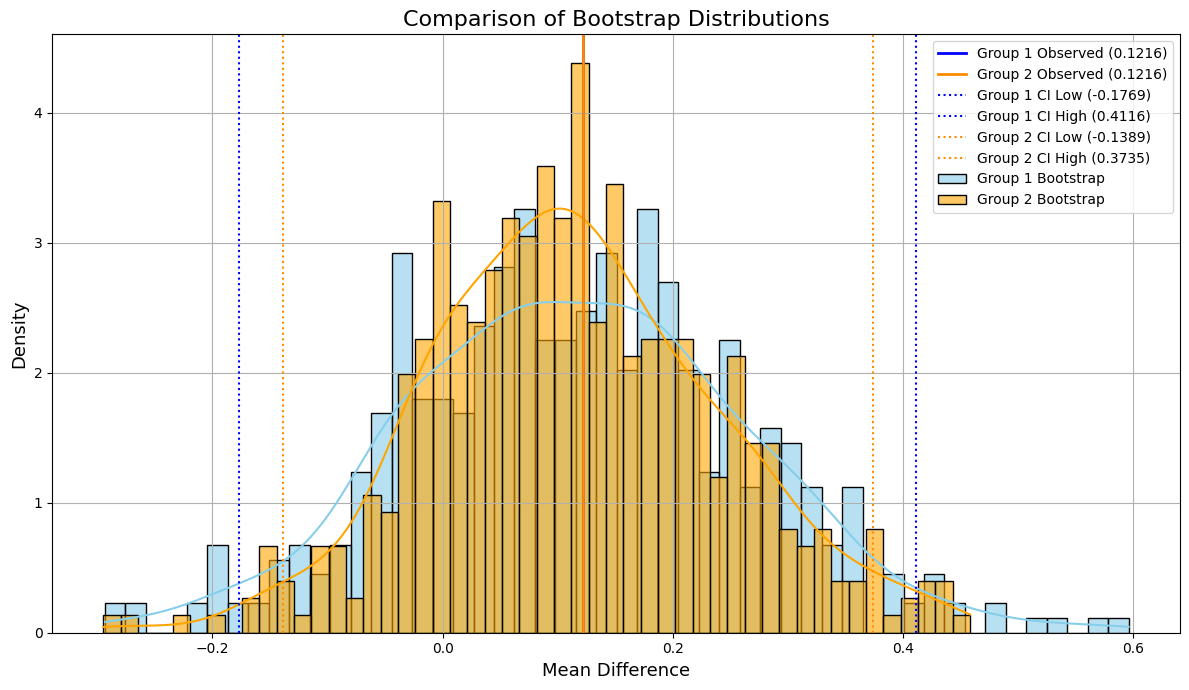

In [52]:
a = raw_cuped_cumm_df[raw_cuped_cumm_df['entity_id'] == 'DJ_CZ']

d = bootstrap_diff_means(a, 'analytical_profit_post')
f = bootstrap_diff_means(a, 'analytical_profit_post_cuped')

plot_bootstrap_comparison_differences_in_means(d, f)

In [51]:
raw_cuped_cumm_df.to_pickle(".holdout_data_latest_cuped.pkl")  

In [27]:
#cleaned_cumm_df['entity_id'].nunique()

55

In [38]:
rr = cleaned_cumm_df.groupby(['entity_id','is_customer_holdout']).agg({'customer_id':'nunique'}).reset_index()

rr.to_csv("customer_counts_by_entity.csv", index=False)


In [21]:
raw_cumm_df.isna().sum()

entity_id                         0
customer_id                       0
is_customer_holdout               0
orders_pre                 87378057
orders_post                87378057
analytical_profit_pre     116229941
analytical_profit_post     96377414
as_of_date                        0
dtype: int64

In [23]:
156146632 - 68194271

87952361

In [120]:
# store_data_cloud(raw_cuped_cumm_df, week_mondays)

In [119]:
# pre_post_metrics = [
#     ("analytical_profit_pre", "analytical_profit_post"),
#     ("orders_pre", "orders_post")
# ]

# apply_cuped_adjustment(a, entities, week_mondays, pre_post_metrics)

# print(result_df)

In [118]:
# result_df

In [117]:
# combined_data()

In [116]:
# bootstrap_single_group(
#     df: pd.DataFrame,
#     adjusted_metric: str,
#     n_resamples: int = 10000,
#     alpha: float = 0.05,
#     seed: int = 42
# ) -> dict:

#  plot_bootstrap_single_distribution(boot_result: dict, alpha: float = 0.05)

#  def plot_bootstrap_comparison_single_group(
#     result1: dict, label1: str,
#     result2: dict, label2: str,
#     alpha: float = 0.05
# ):


# def t_confidence_interval(data, alpha=0.05):

In [115]:
# raw_cuped_cumm_df['as_of_date'].unique()

In [114]:
# a = raw_cuped_cumm_df[(raw_cuped_cumm_df['as_of_date'] == '2025-04-14 00:00:00') & (raw_cuped_cumm_df['entity_id'] == 'FP_PK')]


In [113]:
# a['analytical_profit_post'].describe()

In [112]:
# tt  = bootstrap_single_group(
#    a,
#    "analytical_profit_post"
# )

In [111]:
# bb  = bootstrap_single_group(
#    a,
#    "analytical_profit_pre"
# )

In [110]:
# plot_bootstrap_single_distribution(tt)

In [109]:
# plot_bootstrap_single_distribution(bb)

In [108]:
# t_confidence_interval(data, alpha=0.05)

In [107]:
# tt

In [106]:
# t_confidence_interval(a['analytical_profit_post'].values, alpha=0.05)

In [105]:
# a

In [104]:
# d = bootstrap_diff_means(a, 'analytical_profit_post')

In [103]:
# f = bootstrap_diff_means(a, 'analytical_profit_post_cuped')

In [102]:
# plot_two_bootstrap_distributions(d, f)

In [101]:
# -0.0691 - 0.0886

In [100]:
# plot_bootstrap_distribution(f)

In [99]:
# plot_bootstrap_distribution(d)

In [98]:
# z = welchs_ttest_with_ci(a, 'analytical_profit_post')

In [97]:
# a

In [96]:
# apply_cuped_adjustment()


In [95]:
# from scipy.stats import norm


# # Your input values
# observed_diff = np.float64(0.005175359110324962)
# t_statistic = np.float64(0.13239070542770734)
# p_value = np.float64(0.8946757393529482)
# ci = (np.float64(-0.07144433735825026), np.float64(0.08179505557890018))
# alpha = 0.05

# # Estimate standard error from CI
# z = norm.ppf(1 - alpha / 2)
# se_diff = (ci[1] - observed_diff) / z

# # Plotting function
# def plot_ttest_distribution(observed_diff, se_diff, ci, alpha=0.05, n_points=1000):
#     x = np.linspace(observed_diff - 4*se_diff, observed_diff + 4*se_diff, n_points)
#     y = norm.pdf(x, loc=observed_diff, scale=se_diff)

#     plt.figure(figsize=(10, 6))
#     plt.plot(x, y, label="Sampling Distribution (Normal)", color='skyblue')

#     # Observed difference
#     plt.axvline(observed_diff, color='red', linestyle='-', label='Observed Mean Diff')
#     plt.text(observed_diff, max(y)*0.9, f"{observed_diff:.4f}", color='red', ha='center', va='bottom', fontsize=10)

#     # CI bounds
#     plt.axvline(ci[0], color='black', linestyle='--', label=f'{100*(1-alpha):.0f}% CI')
#     plt.axvline(ci[1], color='black', linestyle='--')
#     plt.text(ci[0], max(y)*0.6, f"{ci[0]:.4f}", color='black', ha='right', va='bottom', fontsize=10)
#     plt.text(ci[1], max(y)*0.6, f"{ci[1]:.4f}", color='black', ha='left', va='bottom', fontsize=10)

#     # Labels and formatting
#     plt.title("Sampling Distribution of Mean Difference (Welch’s t-test)")
#     plt.xlabel("Mean Difference")
#     plt.ylabel("Density")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# # Call the function with computed se_diff
# plot_ttest_distribution(observed_diff, se_diff, ci, alpha)

In [94]:
# plot_ttest_distribution(0.005175359110324962, se_diff, ci, alpha=0.05, n_points=1000):

In [93]:
# a = raw_cuped_cumm_df[raw_cuped_cumm_df['entity_id'] == "FP_PK"]

In [92]:
# raw_cuped_cumm_df

In [91]:
# import matplotlib.pyplot as plt

# results = bootstrap_diff_means(a, "orders_post_cuped")

# # Convert % for plotting
# for r in results:
#     r["mean_pct"] = r["bootstrap_mean_diff"] * 100
#     r["ci_low"] = r["ci"]["diff"][0] * 100
#     r["ci_high"] = r["ci"]["diff"][1] * 100

# # Plot
# fig, ax = plt.subplots(figsize=(9, 3))

# for i, r in enumerate(results):
#     ax.errorbar(r["mean_pct"], i, xerr=[[r["mean_pct"] - r["ci_low"]], [r["ci_high"] - r["mean_pct"]]],
#                 fmt='o', capsize=5, capthick=2, label=r["label"])

#     # Optional: background bar
#     ax.axhspan(i - 0.3, i + 0.3, color='gray', alpha=0.05)

# # Formatting
# ax.axvline(0, color='gray', linestyle='--')
# ax.set_yticks(range(len(results)))
# ax.set_yticklabels([r["label"] for r in results])
# ax.set_xlabel("Uplift (percentage points)")
# ax.set_title("Bootstrapped Differences in Means")
# plt.grid(True, axis='x', linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()

In [90]:
# CI_comparison_single(raw_cuped_cumm_df, "orders_post_cuped","PY_DO", holdout = True)

In [89]:
# CI_comparison_differences(raw_cuped_cumm_df, "orders_post_cuped","PY_DO")

In [88]:
# a = raw_cuped_cumm_df[(raw_cuped_cumm_df["is_customer_holdout"] == True) & (raw_cuped_cumm_df["entity_id"] == "PY_DO")]

In [21]:
# a

,entity_id,customer_id,is_customer_holdout,orders_pre,orders_post,analytical_profit_pre,analytical_profit_post,as_of_date,analytical_profit_post_cuped,orders_post_cuped
50356,PY_DO,16496517,True,11,27,42.628823,90.977305,2025-03-31,52.081002,19.122292
50357,PY_DO,78054397,True,0,1,0.000000,2.754215,2025-03-31,9.396003,5.024267
50358,PY_DO,84376670,True,7,15,25.782875,14.553229,2025-03-31,-6.347449,11.450283
50359,PY_DO,59379790,True,2,3,0.251678,0.636564,2025-03-31,7.009498,4.860272
50360,PY_DO,67657819,True,11,7,34.286351,22.118214,2025-03-31,-7.866272,-0.877708
...,...,...,...,...,...,...,...,...,...,...
61790,PY_DO,20815034,True,0,4,0.000000,5.438421,2025-03-31,12.080209,8.024267
61791,PY_DO,16499131,True,15,18,39.712943,72.608401,2025-03-31,36.826977,5.794301
61792,PY_DO,89269107,True,0,5,0.000000,2.307820,2025-03-31,8.949608,9.024267
61793,PY_DO,41086030,True,3,0,3.558943,0.000000,2025-03-31,2.839960,0.778274


In [87]:
# raw_cuped_cumm_df = apply_cuped_adjustment(cleaned_cumm_df, entities, week_mondays)

In [85]:
# raw_cuped_cumm_df.isna().sum()

In [84]:
# holdout = raw_cuped_cumm_df[(raw_cuped_cumm_df['is_customer_holdout'] == True) & (raw_cuped_cumm_df['entity_id'] == 'PY_DO')]
# non_holdout = raw_cuped_cumm_df[(raw_cuped_cumm_df['is_customer_holdout'] == False) & (raw_cuped_cumm_df['entity_id'] == 'PY_DO')]

In [86]:
# a = bootstrap_single_group(non_holdout, "analytical_profit_post_cuped")
# b = bootstrap_single_group(non_holdout, "analytical_profit_post")

# plot_bootstrap_comparison(a, "Post-CUPED", b, "Post-Raw")

In [81]:
# a = t_confidence_interval(h["analytical_profit_post_cuped"])
# b = t_confidence_interval(h["analytical_profit_post"])

In [82]:
# a

In [83]:
# b

In [80]:
# hb_cuped = bootstrap_single_group(h,"")
# hb_non_cuped = bootstrap_single_group(nh)

In [79]:
# from sklearn.linear_model import Ridge

# X = holdout[['analytical_profit_pre']]
# y = holdout['analytical_profit_post']

# ridge = Ridge(alpha=1.0)
# ridge.fit(X, y)

# theta_ridge = ridge.coef_[0]

# holdout["cuped_ridge"] = (
#     holdout['analytical_profit_post'] - theta_ridge * (holdout['analytical_profit_pre'] - holdout['analytical_profit_pre'].mean())
# )

# print(holdout['cuped_ridge'].mean())

# print("Original variance:", holdout['cuped_standard'].var())
# print("CUPED variance:   ", holdout['cuped_ridge'].var())

# X = non_holdout[['analytical_profit_pre']]
# y = non_holdout['analytical_profit_post']

# ridge = Ridge(alpha=1.0)
# ridge.fit(X, y)

# theta_ridge = ridge.coef_[0]

# non_holdout["cuped_ridge"] = (
#     non_holdout['analytical_profit_post'] - theta_ridge * (non_holdout['analytical_profit_pre'] - non_holdout['analytical_profit_pre'].mean())
# )

# print(non_holdout['cuped_ridge'].mean())

# print("Original variance:", non_holdout['cuped_standard'].var())
# print("CUPED variance:   ", non_holdout['cuped_ridge'].var())



In [78]:
# group_a = test[test["is_customer_holdout"] == False]
# group_b = test[test["is_customer_holdout"] == True]

In [77]:
# a = bootstrap_single_group(
#     group_a,
#     "orders_post"
# )

# b = bootstrap_single_group(
#     group_b,
#     "orders_post"
# )

In [76]:
# a = bootstrap_with_pvalue(test, "orders_post")

In [75]:
# from scipy.stats import norm

# result_ttest = welchs_ttest_with_ci(test, "orders_post")

# # Recalculate standard error using same logic as in your function
# group_a = test[test["is_customer_holdout"] == False]["orders_post"].values
# group_b = test[test["is_customer_holdout"] == True]["orders_post"].values

# se_diff = np.sqrt(np.var(group_a, ddof=1) / len(group_a) + np.var(group_b, ddof=1) / len(group_b))

# # Now plot
# plot_ttest_distribution(
#     observed_diff=result_ttest["observed_diff"],
#     se_diff=se_diff,
#     ci=result_ttest["ci"],
#     alpha=0.05
# )


In [74]:
# plot_bootstrap_distribution(a)


In [73]:
# cleaned_cumm_df[(cleaned_cumm_df['entity_id'] == 'PY_DO') & (cleaned_cumm_df['entity_id'] == 'PY_DO')]

In [72]:
# # Example: conversion rates in two groups
# a = cleaned_cumm_df[(cleaned_cumm_df['entity_id'] == 'PY_DO') & (cleaned_cumm_df['is_customer_holdout'] == True)]['orders_post']
# b = cleaned_cumm_df[(cleaned_cumm_df['entity_id'] == 'PY_DO') & (cleaned_cumm_df['is_customer_holdout'] == False)]['orders_post']

# result = bootstrap_ttest(a, b)

# print(f"Observed diff: {result['observed_diff']:.4f}")
# print(f"P-value: {result['p_value']:.4f}")
# print(f"95% CI: {result['ci']}")

In [71]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.histplot(result["boot_diffs"], bins=50, kde=True)
# plt.axvline(result["observed_diff"], color='red', linestyle='--', label='Observed Diff')
# plt.title("Bootstrapped Distribution of Difference in Means")
# plt.xlabel("Difference in Means")
# plt.legend()
# plt.show()

In [88]:
# ## Define the list of entities that have data in marketing tables ## 
# ## --> rest of the data is extracted from DPS with condition not in the following entities ##

# # mkt_entity_id = tuple(set((
# #     'FP_PK','PY_DO','PY_BO', 'FP_TW', 
# #     'PY_PY', 'DJ_CZ', 'PY_EC','MJM_AT' ,'PY_PE', 'PY_AR',
# #     'PY_GT','PY_SV' ,'FP_PH','PY_NI' ,'NP_HU' ,'FP_MM','EF_GR',
# #     'AP_PA','YS_TR', 'PY_UY' ,'OP_SE' ,'PY_CL' ,'FP_BD' ,'FP_SG',
# #     'FO_NO' ,'PY_CR', 'FP_LA','PY_HN', 'FP_MY' ,'FP_TH', 'FY_CY',
# #     'PY_VE','PO_FI','TB_QA','TB_OM','TB_KW','TB_JO','TB_IQ',
# #     'TB_BH','TB_AE','HS_SA'
# # )))

# mkt_entity_id = (
#     'FP_PK','PY_DO'
# )


# client = initialize_bigquery_client(project)

# final_df = pd.DataFrame()  # Empty DataFrame to store the results

# for m in week_mondays:
#     print(f"Querying for week starting {m}")
    
#     # Run your query
#     test = client.query(marketing_data(mkt_entity_id, m)).to_dataframe()

#     # Add the as_of_date column
#     test["as_of_date"] = m

#     # Append to the final dataframe
#     final_df = pd.concat([final_df, test], ignore_index=True)

In [89]:
# get_cumm_data(project, mkt_entity_id, week_mondays)

In [70]:
# week_mondays

In [70]:
# extract_data(project, get_marketing_data(mkt_entity_id, '2025-02-03'), get_dps_data(mkt_entity_id, '2025-02-03'))

In [71]:
# a = fill_nans(final_df)

In [72]:
# b = drop_users_with_no_data(a)

In [73]:
# b

In [74]:
# c = b[b['as_of_date'] == date(2025, 2, 3)]


In [75]:
# d = c[c['entity_id'] == 'FP_PK']

In [76]:
# d.describe()

In [69]:
# d[d['orders_pre'] < ]['orders_pre'].hist()

In [67]:
# d[d['orders_post'] > 100]

In [68]:
# df = drop_users_with_no_data(raw_data)